# Solar Generation Forecast

- Energy Traders making bets on renewable generation and its contribution to meeting energy demand.
- Day Ahead Planners in utilities preparing for or short-term planning horizons
- Calculating vital metrics such as Net Demand. I
- Initializing Power Flow simulation models

## Librairies

In [3]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import pvlib
import urllib
import requests
import geocoder
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from pvlib import solarposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from pvlib import location as pvlib_location
from datetime import timedelta
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

from plotly.subplots import make_subplots
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt
import optuna
import plotly.express as px
import plotly.graph_objects as go
import random
import seaborn as sns
import statsmodels.api as sm
import time
import xgboost as xgb


## Dataset

In [4]:
# Specify the file path of the Excel file
file_path = 'CAISO Total Solar Historical Actuals.xlsx'

# Specify the sheet name
sheet_name = 'CAISO Total System Solar Power '

# Read the specified range in the specified sheet
df1= pd.read_excel(file_path, sheet_name=sheet_name, header=2)
# df['Date'] = pd.to_datetime(df['Date'])

# Print the DataFrame
print(df1)

            Date  Hour  Actual
0     2020-05-16     1       0
1     2020-05-16     2       0
2     2020-05-16     3       0
3     2020-05-16     4       0
4     2020-05-16     5       0
...          ...   ...     ...
26188 2023-05-14    20     874
26189 2023-05-14    21       0
26190 2023-05-14    22       3
26191 2023-05-14    23       7
26192 2023-05-14    24       6

[26193 rows x 3 columns]


## Explanatory Data Analysis

In [5]:
# Find duplicate records
duplicates = df1.duplicated()
# Print the number of duplicate records
print('Number of duplicate records:', duplicates.sum())

Number of duplicate records: 5


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26193 entries, 0 to 26192
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    26193 non-null  datetime64[ns]
 1   Hour    26193 non-null  int64         
 2   Actual  26193 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 614.0 KB


In [7]:
df1.isnull().sum()

Date      0
Hour      0
Actual    0
dtype: int64

In [8]:
# Combine the 'Date' and 'Hour' columns into a new column
df1['DateTime'] = pd.to_datetime(df1['Date']) + pd.to_timedelta(df1['Hour'], unit='h')

# This line adjust the date at midnight hours to be consistent with date in the "Actuals data"
#df1.loc[df1['DateTime'].apply(lambda x:x.hour)==0, 'DateTime'] = df1.loc[df1['DateTime'].apply(lambda x:x.hour)==0, 'DateTime'].apply(lambda x:x-timedelta(days=1))

print(df1.head())

# Create a line plot using Plotly
fig = px.line(df1, x='DateTime', y='Actual')

# Set the title and labels
fig.update_layout(title='Actual Values by Hour',
                  xaxis_title='Date and Hour',
                  yaxis_title='Actual Values')

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Display the plot
fig.show()

        Date  Hour  Actual            DateTime
0 2020-05-16     1       0 2020-05-16 01:00:00
1 2020-05-16     2       0 2020-05-16 02:00:00
2 2020-05-16     3       0 2020-05-16 03:00:00
3 2020-05-16     4       0 2020-05-16 04:00:00
4 2020-05-16     5       0 2020-05-16 05:00:00


In [9]:
# Create the line plot
fig = px.line(df1, x='Hour', y='Actual', color='Date', title='Actual Values by Hour')

# Set the axis labels
fig.update_layout(xaxis_title='Hour', yaxis_title='Actual')

# Show the plot
fig.show()

In [10]:
# Reorder the columns
df1 = df1.reindex(columns=['DateTime', 'Date', 'Hour', 'Actual'])

# Print the updated DataFrame
print(df1)

                 DateTime       Date  Hour  Actual
0     2020-05-16 01:00:00 2020-05-16     1       0
1     2020-05-16 02:00:00 2020-05-16     2       0
2     2020-05-16 03:00:00 2020-05-16     3       0
3     2020-05-16 04:00:00 2020-05-16     4       0
4     2020-05-16 05:00:00 2020-05-16     5       0
...                   ...        ...   ...     ...
26188 2023-05-14 20:00:00 2023-05-14    20     874
26189 2023-05-14 21:00:00 2023-05-14    21       0
26190 2023-05-14 22:00:00 2023-05-14    22       3
26191 2023-05-14 23:00:00 2023-05-14    23       7
26192 2023-05-15 00:00:00 2023-05-14    24       6

[26193 rows x 4 columns]


## Retrieve Carlifornia region info

In [11]:
# Function to retrieve altitude (elevation) based on latitude and longitude
def get_altitude(latitude, longitude):
    geolocator = Nominatim(user_agent='my-app')
    location = geolocator.reverse(f'{latitude}, {longitude}', exactly_one=True)
    if location.raw.get('elevation'):
        return location.raw['elevation']
    else:
        return None

# Specify the regions
regions = ['Northern California', 'Central California', 'Southern California']
# regions = 'California' #different results


# Create a geocoder instance
geolocator = Nominatim(user_agent='my-app')

# Initialize empty lists for latitude and longitude
latitudes = []
longitudes = []

# Loop through the regions and retrieve the coordinates
for region in regions:
    # Retrieve the location for the region
    location = geolocator.geocode(region)
    
    # Extract the latitude and longitude
    latitude = location.latitude
    longitude = location.longitude
    
    # Append the coordinates to the respective lists
    latitudes.append(latitude)
    longitudes.append(longitude)

# Calculate the average coordinates
avg_latitude = sum(latitudes) / len(latitudes)
avg_longitude = sum(longitudes) / len(longitudes)

# Rounding the values of both lat and lon due to locator limits
avg_latitude = round(avg_latitude, ndigits=6)
avg_longitude = round(avg_longitude, ndigits=6)

# Print the average coordinates
print("Average Latitude:", avg_latitude)
print("Average Longitude:", avg_longitude)

# Retrieve the altitude (elevation) based on the latitude and longitude
# if get_altitude(latitude, longitude) == None: elevation = 0
# else: elevation = get_altitude(latitude, longitude)


# printing the address/location name
location = geolocator.reverse([avg_latitude, avg_longitude])
print(location.address)

Average Latitude: 37.051548
Average Longitude: -120.699371
CA 152;CA 33, Merced County, California, United States


In [12]:
# Altitude
# URL
url = r'https://epqs.nationalmap.gov/v1/json?'

# coordinates with known elevation 
lat = [avg_latitude]
lon = [avg_longitude]
   
# create data frame
df_alt = pd.DataFrame({
    'lat': lat,
    'lon': lon
})

def elevation_function(df, lat_column, lon_column):
    """Query service using lat, lon. add the elevation values as a new column."""
    elevations = []
    for lat, lon in zip(df[lat_column], df[lon_column]):
                
        # define rest query params
        params = {
            'output': 'json',
            'x': lon,
            'y': lat,
            'units': 'Meters'
        }
        
        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        #elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])
        #new 2023:
        elevations.append(result.json()['value'])

    df['elev_meters'] = elevations

elevation_function(df_alt, 'lat', 'lon')
df_alt.head()
avg_altitude = df_alt.iloc[0,2]
print(avg_altitude)

31.188999176


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


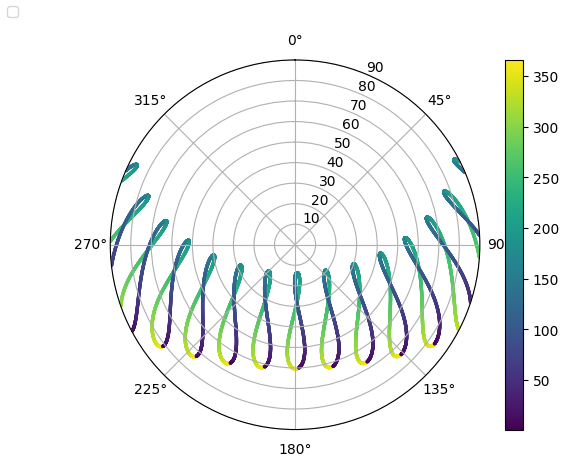

In [13]:
tz = 'America/Los_Angeles'
lat, lon = avg_latitude, avg_longitude

times = pd.date_range(df1['Date'].min(), df1['Date'].max(), freq='H', tz=tz)
solpos = solarposition.get_solarposition(times, lat, lon)
# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

ax = plt.subplot(1, 1, 1, projection='polar')
# draw the analemma loops
points = ax.scatter(np.radians(solpos.azimuth), solpos.apparent_zenith,
                    s=2, label=None, c=solpos.index.dayofyear)
ax.figure.colorbar(points)

# # draw hour labels
# for hour in np.unique(solpos.index.hour):
#     # choose label position by the smallest radius for each hour
#     subset = solpos.loc[solpos.index.hour == hour, :]
#     r = subset.apparent_zenith
#     pos = solpos.loc[r.idxmin(), :]
#     ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))

# # draw individual days
# for date in df1['Date']:
#     times = pd.date_range(date, date+pd.Timedelta('24h'), freq='H', tz=tz)
#     solpos = solarposition.get_solarposition(times, lat, lon)
#     solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
#     label = date.strftime('%Y-%m-%d')
#     ax.plot(np.radians(solpos.azimuth), solpos.apparent_zenith, label=label)

ax.figure.legend(loc='upper left')

# change coordinates to be like a compass
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)

plt.show()

## Opening the retrieved location data

In [14]:
# Specify the path to your CSV file
csv_file_path = 'history_bulk_location.csv'

# Read the CSV file and create a DataFrame
df2 = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df2.head())

           dt                         dt_iso  timezone        city_name  \
0  1589500800  2020-05-15 00:00:00 +0000 UTC    -25200  Custom location   
1  1589504400  2020-05-15 01:00:00 +0000 UTC    -25200  Custom location   
2  1589508000  2020-05-15 02:00:00 +0000 UTC    -25200  Custom location   
3  1589511600  2020-05-15 03:00:00 +0000 UTC    -25200  Custom location   
4  1589515200  2020-05-15 04:00:00 +0000 UTC    -25200  Custom location   

         lat         lon   temp  visibility  dew_point  feels_like  ...  \
0  37.051548 -120.699371  24.14         NaN      12.77       23.89  ...   
1  37.051548 -120.699371  23.75         NaN      13.02       23.51  ...   
2  37.051548 -120.699371  21.51         NaN      13.93       21.34  ...   
3  37.051548 -120.699371  20.67         NaN      13.86       20.49  ...   
4  37.051548 -120.699371  18.86         NaN      13.92       18.71  ...   

   wind_gust  rain_1h  rain_3h  snow_1h  snow_3h  clouds_all  weather_id  \
0        NaN      NaN 

In [15]:
# Get the number of columns and rows
num_columns = df2.shape[1]
num_rows = df2.shape[0]

# Display the number of columns and rows
print("Number of columns:", num_columns)
print("Number of rows:", num_rows)

Number of columns: 28
Number of rows: 26304


In [16]:
# Find duplicate records
duplicates = df2.duplicated()
# Print the number of duplicate records
print('Number of duplicate records:', duplicates.sum())

Number of duplicate records: 0


In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   26304 non-null  int64  
 1   dt_iso               26304 non-null  object 
 2   timezone             26304 non-null  int64  
 3   city_name            26304 non-null  object 
 4   lat                  26304 non-null  float64
 5   lon                  26304 non-null  float64
 6   temp                 26304 non-null  float64
 7   visibility           0 non-null      float64
 8   dew_point            26299 non-null  float64
 9   feels_like           26304 non-null  float64
 10  temp_min             26304 non-null  float64
 11  temp_max             26304 non-null  float64
 12  pressure             26304 non-null  int64  
 13  sea_level            0 non-null      float64
 14  grnd_level           0 non-null      float64
 15  humidity             26304 non-null 

In [18]:
df2.isnull().sum()

dt                         0
dt_iso                     0
timezone                   0
city_name                  0
lat                        0
lon                        0
temp                       0
visibility             26304
dew_point                  5
feels_like                 0
temp_min                   0
temp_max                   0
pressure                   0
sea_level              26304
grnd_level             26304
humidity                   0
wind_speed                 0
wind_deg                   0
wind_gust              26304
rain_1h                25188
rain_3h                26304
snow_1h                26304
snow_3h                26304
clouds_all                 0
weather_id                 0
weather_main               0
weather_description        0
weather_icon               0
dtype: int64

Cleaning the retrieved dataset

In [19]:
# List of column names to drop
columns_to_drop = ['dt','timezone','visibility', 'sea_level', 'grnd_level', 'wind_gust', 'rain_3h', 'snow_1h','snow_3h']

# Drop the specified columns
df2 = df2.drop(columns=columns_to_drop)

# Remove '+0000 UTC' from 'dt_iso' column
df2['dt_iso'] = df2['dt_iso'].str.replace('+0000 UTC', '')

# Convert 'dt_iso' column to datetime64[ns]
df2['dt_iso'] = pd.to_datetime(df2['dt_iso'])

# Adjusting the time to UTC-7 due to the location
df2['dt_iso'] = df2['dt_iso'] - timedelta(hours=7)

# Replace all values in 'city_name' column with 'Dos Palos' instead of 'Custom location'
df2['city_name'] = 'Dos Palos Y'

# Get the number of columns and rows
num_columns = df2.shape[1]
num_rows = df2.shape[0]

# Display the number of columns and rows
print("Number of columns:", num_columns)
print("Number of rows:", num_rows)

# Display the updated DataFrame
print(df2.head())

Number of columns: 19
Number of rows: 26304
               dt_iso    city_name        lat         lon   temp  dew_point  \
0 2020-05-14 17:00:00  Dos Palos Y  37.051548 -120.699371  24.14      12.77   
1 2020-05-14 18:00:00  Dos Palos Y  37.051548 -120.699371  23.75      13.02   
2 2020-05-14 19:00:00  Dos Palos Y  37.051548 -120.699371  21.51      13.93   
3 2020-05-14 20:00:00  Dos Palos Y  37.051548 -120.699371  20.67      13.86   
4 2020-05-14 21:00:00  Dos Palos Y  37.051548 -120.699371  18.86      13.92   

   feels_like  temp_min  temp_max  pressure  humidity  wind_speed  wind_deg  \
0       23.89     23.28     25.13      1017        49        4.01       295   
1       23.51     22.21     24.50      1016        51        4.24       291   
2       21.34     21.11     23.40      1016        62        4.47       288   
3       20.49     19.85     22.19      1017        65        3.93       285   
4       18.71     18.33     20.16      1017        73        3.68       282   

   rai

## Joining the two datasets together

In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26193 entries, 0 to 26192
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  26193 non-null  datetime64[ns]
 1   Date      26193 non-null  datetime64[ns]
 2   Hour      26193 non-null  int64         
 3   Actual    26193 non-null  int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 818.7 KB


In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dt_iso               26304 non-null  datetime64[ns]
 1   city_name            26304 non-null  object        
 2   lat                  26304 non-null  float64       
 3   lon                  26304 non-null  float64       
 4   temp                 26304 non-null  float64       
 5   dew_point            26299 non-null  float64       
 6   feels_like           26304 non-null  float64       
 7   temp_min             26304 non-null  float64       
 8   temp_max             26304 non-null  float64       
 9   pressure             26304 non-null  int64         
 10  humidity             26304 non-null  int64         
 11  wind_speed           26304 non-null  float64       
 12  wind_deg             26304 non-null  int64         
 13  rain_1h              1116 non-n

In [22]:
# Perform the left join
data = pd.merge(df1, df2, left_on='DateTime', right_on='dt_iso', how='left')

# Drop the specified columns
data = data.drop(columns='dt_iso')

# Convert Datetime object to Datetime object with time zone (this is needed for proper merging with GHI dataframe)
data.set_index('DateTime',inplace=True)
data = data.tz_localize(tz="America/Los_Angeles", ambiguous='NaT')
data['DateTime'] = data.index
data.reset_index(drop=True, inplace = True)

# Display the merged DataFramedf1
print(data)

                 DateTime       Date  Hour  Actual    city_name        lat  \
0     2020-05-16 01:00:00 2020-05-16     1       0  Dos Palos Y  37.051548   
1     2020-05-16 02:00:00 2020-05-16     2       0  Dos Palos Y  37.051548   
2     2020-05-16 03:00:00 2020-05-16     3       0  Dos Palos Y  37.051548   
3     2020-05-16 04:00:00 2020-05-16     4       0  Dos Palos Y  37.051548   
4     2020-05-16 05:00:00 2020-05-16     5       0  Dos Palos Y  37.051548   
...                   ...        ...   ...     ...          ...        ...   
26188 2023-05-14 20:00:00 2023-05-14    20     874  Dos Palos Y  37.051548   
26189 2023-05-14 21:00:00 2023-05-14    21       0  Dos Palos Y  37.051548   
26190 2023-05-14 22:00:00 2023-05-14    22       3  Dos Palos Y  37.051548   
26191 2023-05-14 23:00:00 2023-05-14    23       7  Dos Palos Y  37.051548   
26192 2023-05-15 00:00:00 2023-05-14    24       6  Dos Palos Y  37.051548   

              lon   temp  dew_point  feels_like  ...  pressure 

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26193 entries, 0 to 26192
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DateTime             26193 non-null  datetime64[ns]
 1   Date                 26193 non-null  datetime64[ns]
 2   Hour                 26193 non-null  int64         
 3   Actual               26193 non-null  int64         
 4   city_name            26193 non-null  object        
 5   lat                  26193 non-null  float64       
 6   lon                  26193 non-null  float64       
 7   temp                 26193 non-null  float64       
 8   dew_point            26188 non-null  float64       
 9   feels_like           26193 non-null  float64       
 10  temp_min             26193 non-null  float64       
 11  temp_max             26193 non-null  float64       
 12  pressure             26193 non-null  int64         
 13  humidity             26193 non-

## Cleaning memory usage

In [24]:

# # Get all variables in the current scope
# all_variables = list(locals().keys())

# # Delete all variables except 'merged_df'
# for variable in all_variables:
#     if variable != 'data':
#         del locals()[variable]

# # Display the merged DataFrame
# print(data)

In [25]:
print(data.head())

             DateTime       Date  Hour  Actual    city_name        lat  \
0 2020-05-16 01:00:00 2020-05-16     1       0  Dos Palos Y  37.051548   
1 2020-05-16 02:00:00 2020-05-16     2       0  Dos Palos Y  37.051548   
2 2020-05-16 03:00:00 2020-05-16     3       0  Dos Palos Y  37.051548   
3 2020-05-16 04:00:00 2020-05-16     4       0  Dos Palos Y  37.051548   
4 2020-05-16 05:00:00 2020-05-16     5       0  Dos Palos Y  37.051548   

          lon   temp  dew_point  feels_like  ...  pressure  humidity  \
0 -120.699371  16.31       7.53       15.46  ...      1015        56   
1 -120.699371  15.83       7.59       14.98  ...      1014        58   
2 -120.699371  15.69       7.46       14.83  ...      1014        58   
3 -120.699371  14.30       7.82       13.48  ...      1014        65   
4 -120.699371  14.27       8.23       13.50  ...      1014        67   

   wind_speed  wind_deg  rain_1h  clouds_all  weather_id  weather_main  \
0        2.16       249      NaN          83    

In [26]:
print(data.tail())

                 DateTime       Date  Hour  Actual    city_name        lat  \
26188 2023-05-14 20:00:00 2023-05-14    20     874  Dos Palos Y  37.051548   
26189 2023-05-14 21:00:00 2023-05-14    21       0  Dos Palos Y  37.051548   
26190 2023-05-14 22:00:00 2023-05-14    22       3  Dos Palos Y  37.051548   
26191 2023-05-14 23:00:00 2023-05-14    23       7  Dos Palos Y  37.051548   
26192 2023-05-15 00:00:00 2023-05-14    24       6  Dos Palos Y  37.051548   

              lon   temp  dew_point  feels_like  ...  pressure  humidity  \
26188 -120.699371  23.44      10.50       22.99  ...      1010        44   
26189 -120.699371  22.27       9.10       21.68  ...      1011        43   
26190 -120.699371  21.43       9.66       20.86  ...      1012        47   
26191 -120.699371  19.90      10.87       19.41  ...      1013        56   
26192 -120.699371  17.88      10.75       17.37  ...      1014        63   

       wind_speed  wind_deg  rain_1h  clouds_all  weather_id  weather_main

In [27]:
# Setting the coordinates
lat, long, alt = avg_latitude, avg_longitude, avg_altitude

#create location instance to be used for generating HI data
location = pvlib_location.Location(latitude=lat,longitude=long, tz="America/Los_Angeles")


#create time range to use for generating HI data
time = pd.date_range(start='5/16/2020', end='5/15/2023', tz=location.tz, freq='1H')
time_ = pd.date_range(start='5/16/2020', end='5/15/2023', freq='1H')

#generate HI data and formate the df
HI = location.get_clearsky(time)
HI['DateTime_DST'] = time
HI['DateTime']=time_
HI.reset_index(drop=True,inplace=True)
HI['Hour'] = HI['DateTime'].apply(lambda x:x.hour)
HI['Hour_DST'] = HI['DateTime_DST'].apply(lambda x:x.hour)
HI['Hour'].replace(0, 24, inplace=True)
#HI.loc[HI['Hour']==24, 'DateTime'] = HI.loc[HI['Hour']==24, 'DateTime'].apply(lambda x:x-timedelta(days=1))
#HI.loc[HI['Hour']==24, 'DateTime_DST'] = HI.loc[HI['Hour']==24, 'DateTime_DST'].apply(lambda x:x-timedelta(days=1))
HI['year'] = HI['DateTime'].apply(lambda x:x.year)
HI['month'] = HI['DateTime'].apply(lambda x:x.month)
HI['week'] = HI['DateTime'].apply(lambda x:x.isocalendar().week)
HI['day'] = HI['DateTime'].apply(lambda x:x.day)

HI = HI.drop(labels=0, axis=0)
HI.reset_index(drop=True,inplace=True)

In [28]:
# Perform the left join
data_full = pd.merge(data, HI, left_on='DateTime', right_on='DateTime_DST', how='left')

# Drop the specified columns
data_full = data_full.drop(columns=['Hour_y','DateTime_y'])
data_full.rename(columns = {'Hour_x':'Hour', 'DateTime_x':'DateTime'}, inplace = True)

In [29]:
#data_full.to_csv('full_data.csv', encoding='utf-8')

## Full Data Explanatory Analysis

In [30]:
#Printing the dataset
print(data_full)

                 DateTime       Date  Hour  Actual    city_name        lat  \
0     2020-05-16 01:00:00 2020-05-16     1       0  Dos Palos Y  37.051548   
1     2020-05-16 02:00:00 2020-05-16     2       0  Dos Palos Y  37.051548   
2     2020-05-16 03:00:00 2020-05-16     3       0  Dos Palos Y  37.051548   
3     2020-05-16 04:00:00 2020-05-16     4       0  Dos Palos Y  37.051548   
4     2020-05-16 05:00:00 2020-05-16     5       0  Dos Palos Y  37.051548   
...                   ...        ...   ...     ...          ...        ...   
26188 2023-05-14 20:00:00 2023-05-14    20     874  Dos Palos Y  37.051548   
26189 2023-05-14 21:00:00 2023-05-14    21       0  Dos Palos Y  37.051548   
26190 2023-05-14 22:00:00 2023-05-14    22       3  Dos Palos Y  37.051548   
26191 2023-05-14 23:00:00 2023-05-14    23       7  Dos Palos Y  37.051548   
26192 2023-05-15 00:00:00 2023-05-14    24       6  Dos Palos Y  37.051548   

              lon   temp  dew_point  feels_like  ...  weather_i

In [31]:
data_full.columns

Index(['DateTime', 'Date', 'Hour', 'Actual', 'city_name', 'lat', 'lon', 'temp',
       'dew_point', 'feels_like', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all',
       'weather_id', 'weather_main', 'weather_description', 'weather_icon',
       'ghi', 'dni', 'dhi', 'DateTime_DST', 'Hour_DST', 'year', 'month',
       'week', 'day'],
      dtype='object')

In [32]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26193 entries, 0 to 26192
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype                              
---  ------               --------------  -----                              
 0   DateTime             26193 non-null  datetime64[ns]                     
 1   Date                 26193 non-null  datetime64[ns]                     
 2   Hour                 26193 non-null  int64                              
 3   Actual               26193 non-null  int64                              
 4   city_name            26193 non-null  object                             
 5   lat                  26193 non-null  float64                            
 6   lon                  26193 non-null  float64                            
 7   temp                 26193 non-null  float64                            
 8   dew_point            26188 non-null  float64                            
 9   feels_like           26193 n

## Exploring Actual power generation and GHI

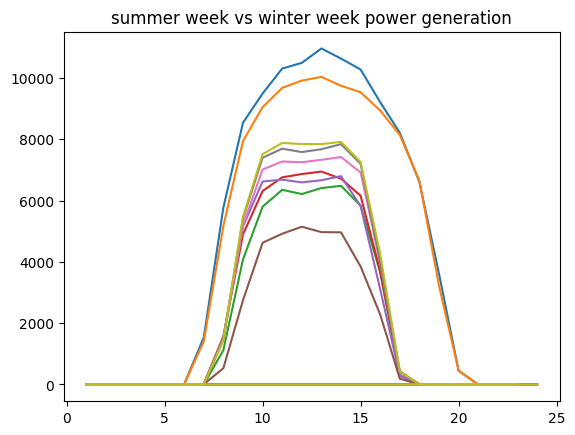

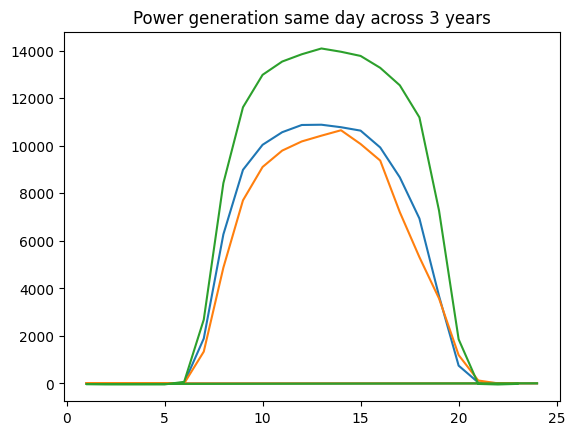

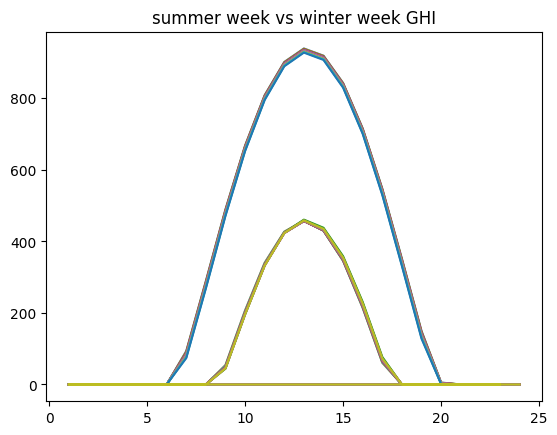

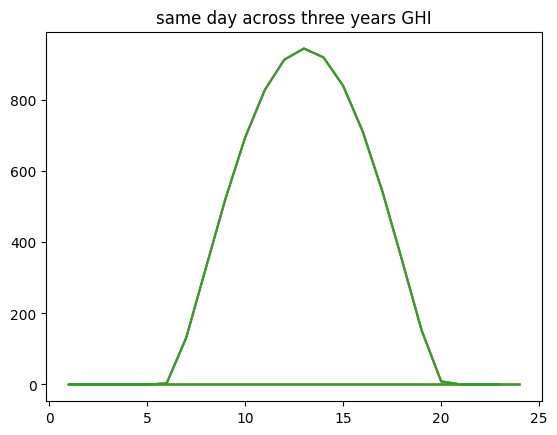

In [33]:
#summer week vs winter week power generation
plt.figure()
plt.title('summer week vs winter week power generation')
for y in [2020]:
    data_y = data_full[data_full['year']==y].copy()

    for i in [20,51]:
        data_w = data_y[data_y['week']==i].copy()
    #     plt.figure()
        for j in data_w['day'].unique():
            plt.plot(data_w[data_w['day']==j]['Hour'],data_w[data_w['day']==j]['Actual'])
    
    
    

#same day across three years power generation
#day weather may be important to consider
plt.figure()
plt.title('Power generation same day across 3 years')
for i in [6]:
    data_m = data_full[data_full['month']==i].copy()

    for y in [2020,2021,2022]:
        data_y = data_m[data_m['year']==y].copy()
    
        for j in [15]:
            plt.plot(data_y[data_y['day']==j]['Hour'],data_y[data_y['day']==j]['Actual'])

            
            

#summer week vs winter week ghi
#similar observation to power generation
plt.figure()
plt.title('summer week vs winter week GHI')
for y in [2020,2022]:
    data_y_ = data_full[data_full['year']==y].copy()

    for i in [30,52]:
        data_w_ = data_y_[data_y_['week']==i].copy()
    #     plt.figure()
        for j in data_w_['day'].unique():
            plt.plot(data_w_[data_w_['day']==j]['Hour'],data_w_[data_w_['day']==j]['ghi'])

            

#same day across three years GHI
#clearsky GHI is not affected by day weather, therefore, day weather from external source may be important to consider
plt.figure()
plt.title('same day across three years GHI')
for i in [6]:
    data_m = HI[HI['month']==i].copy()

    for y in [2020,2021,2022]:
        data_y = data_m[data_m['year']==y].copy()
    
        for j in [15]:
            plt.plot(data_y[data_y['day']==j]['Hour'],data_y[data_y['day']==j]['ghi'])

## Exploring GHI and cloud cover effect on actual power generation

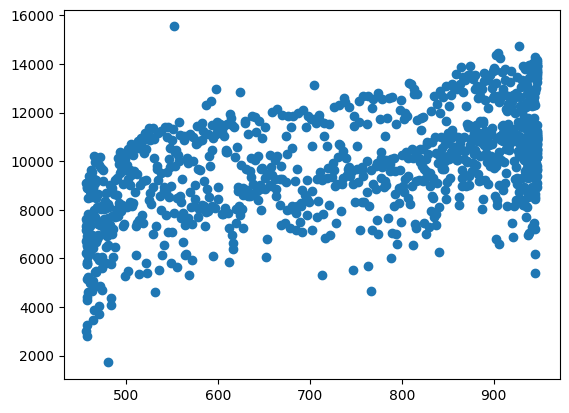

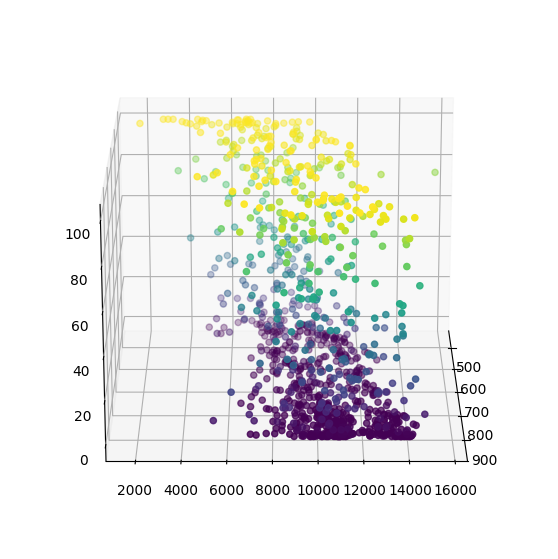

In [34]:

#Exploring GHI and cloud cover effect on actual power generation

filtered = data_full.copy()
filtered = filtered[filtered['Hour']==13].copy()
filtered = filtered[filtered['clouds_all']<=100].copy()

x = filtered['ghi'].copy()
y = filtered['Actual'].copy()
z = filtered['clouds_all'].copy()

#Correlation between daily GHI at 13:00 pm & actual power generation (try changing time to 7:00 am & 19:00 pm)
plt.scatter(x,y)


#same correlation as above but on 3d plot with "clouds_all" in z direction
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=z)
ax.view_init(90,-90 )


#Correlation between actual power generation at 13:00 pm & cloud cover (try changing time to 7:00 am & 19:00 pm)
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=z)
ax.view_init(20, 0)


## 3 weeks actual power generation & cloud cover
### Time series is a potential modeling approach

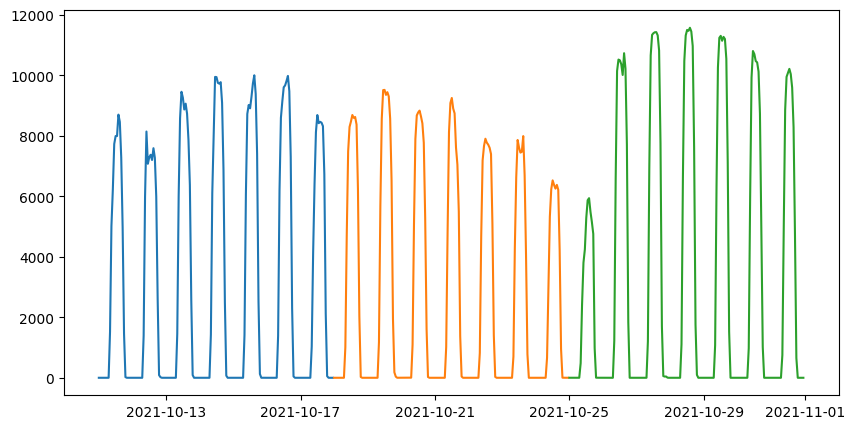

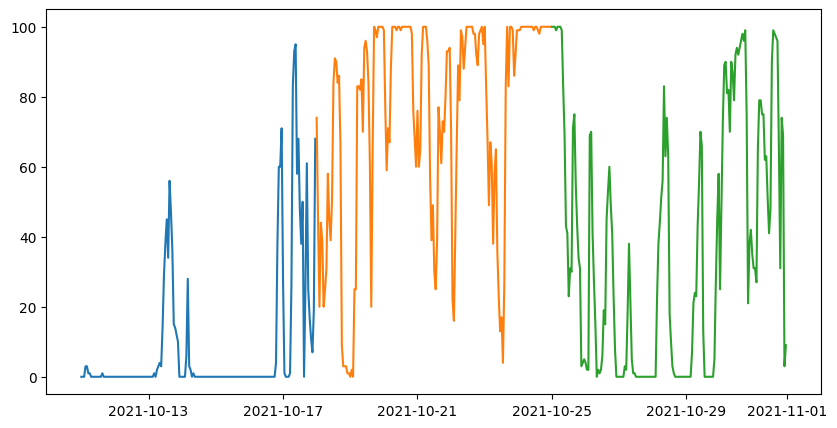

In [35]:
#Time series is a potential modeling approach 


plt.figure(figsize=(10,5))
for y in [2021]:
    data_y = data_full[data_full['year']==y].copy()
    #data_y = data_y[data_y['DateTime']!=24].copy()
    

    for i in [41,42,43]:
        data_w = data_y[data_y['week']==i].copy()
        #data_w.drop(data_w.tail(1).index,inplace=True)
        plt.plot(data_w['DateTime'],data_w['Actual'])
            
        
plt.figure(figsize=(10,5))
for y in [2021]:
    data_y = data_full[data_full['year']==y].copy()
    #data_y = data_y[data_y['Hour']!=24].copy()
    

    for i in [41,42,43]:
        data_w = data_y[data_y['week']==i].copy()
        #data_w.drop(data_w.tail(1).index,inplace=True)
        plt.plot(data_w['DateTime'],data_w['clouds_all'])
        
        
# plt.figure(figsize=(10,5))
# for y in [2021]:
#     data_y = data_full[data_full['year']==y].copy()
#     #data_y = data_y[data_y['Hour']!=24].copy()
    

#     for i in [41,42,43]:
#         data_w = data_y[data_y['week']==i].copy()
#         #data_w.drop(data_w.tail(1).index,inplace=True)
#         plt.plot(data_w['DateTime'],data_w['temp'])

## Data Engineering

In [36]:
import seaborn as sns
# sns.pairplot(data_full)

Based on the above graph, we can see some patterns in the data which would indicate some correlation among some variables.

Generating a correlation matrix

In [37]:
# copying the data_full
subset = data_full.copy()

# Specify the columns to drop
columns_todrop = ['DateTime', 'Date', 'DateTime_DST', 'city_name', 
                  'weather_main', 'weather_description', 'weather_icon']

# Drop the specified columns from the DataFrame
subset = subset.drop(columns=columns_todrop, axis=1)

# Generate the heatmap with increased size
plt.figure(figsize=(20, 20) ) # Set the size of the figure

# Plot the heatmap
sns.heatmap(subset.corr(), cmap='cool', annot=True)

# Display the plot
plt.show()

From the correlation matrix, we ca see that we would need to remove some variables:

We will remove the below variables as their percentage is greater than 80%:

    -All of the DST timestamp as we have a timestamp with date + hour
    -Week as we have date column
    -month as we have date column
    -dni and dhi as both are used to calculate ghi
    -weather id as we have the weather details
    -feels like as we have the exact temperature
    -temp min

In [38]:
import pandas as pd

# Create a copy of the original dataframe
final_df = data_full.copy()

# Remove the specified columns
columns_to_remove = ['DateTime_DST', 'Hour_DST', 'week', 'Date', 'dni', 'dhi', 'temp_min', 'feels_like', 'weather_id',
                     'city_name', 'lat', 'lon']
final_df.drop(columns=columns_to_remove, inplace=True)

# changing the index
final_df.set_index('DateTime', inplace=True)

# Reorder columns alphabetically
final_df = final_df.reindex(sorted(final_df.columns), axis=1)

# Move 'ghi' column to the first position
columns = final_df.columns.tolist()
columns.insert(0, columns.pop(columns.index('Actual')))
final_df = final_df[columns]

# Print the resulting dataframe
print(final_df)


                     Actual  Hour  clouds_all  day  dew_point       ghi  \
DateTime                                                                  
2020-05-16 01:00:00       0     1          83   16       7.53  0.000000   
2020-05-16 02:00:00       0     2          87   16       7.59  0.000000   
2020-05-16 03:00:00       0     3          95   16       7.46  0.000000   
2020-05-16 04:00:00       0     4          88   16       7.82  0.000000   
2020-05-16 05:00:00       0     5          76   16       8.23  0.000000   
...                     ...   ...         ...  ...        ...       ...   
2023-05-14 20:00:00     874    20           0   14      10.50  0.022971   
2023-05-14 21:00:00       0    21           0   14       9.10  0.000000   
2023-05-14 22:00:00       3    22           0   14       9.66  0.000000   
2023-05-14 23:00:00       7    23           0   14      10.87  0.000000   
2023-05-15 00:00:00       6    24           1   15      10.75  0.000000   

                     hum

In [39]:
final_df.columns

Index(['Actual', 'Hour', 'clouds_all', 'day', 'dew_point', 'ghi', 'humidity',
       'month', 'pressure', 'rain_1h', 'temp', 'temp_max',
       'weather_description', 'weather_icon', 'weather_main', 'wind_deg',
       'wind_speed', 'year'],
      dtype='object')

In [40]:
# Identify categorical and numerical columns
CAT = final_df.select_dtypes(include=['object']).columns.tolist()
NUM = final_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Print the categorical and numerical columns
print("Categorical Columns:", CAT)
print("Numerical Columns:", NUM)


Categorical Columns: ['weather_description', 'weather_icon', 'weather_main']
Numerical Columns: ['Actual', 'Hour', 'clouds_all', 'day', 'dew_point', 'ghi', 'humidity', 'month', 'pressure', 'rain_1h', 'temp', 'temp_max', 'wind_deg', 'wind_speed', 'year']


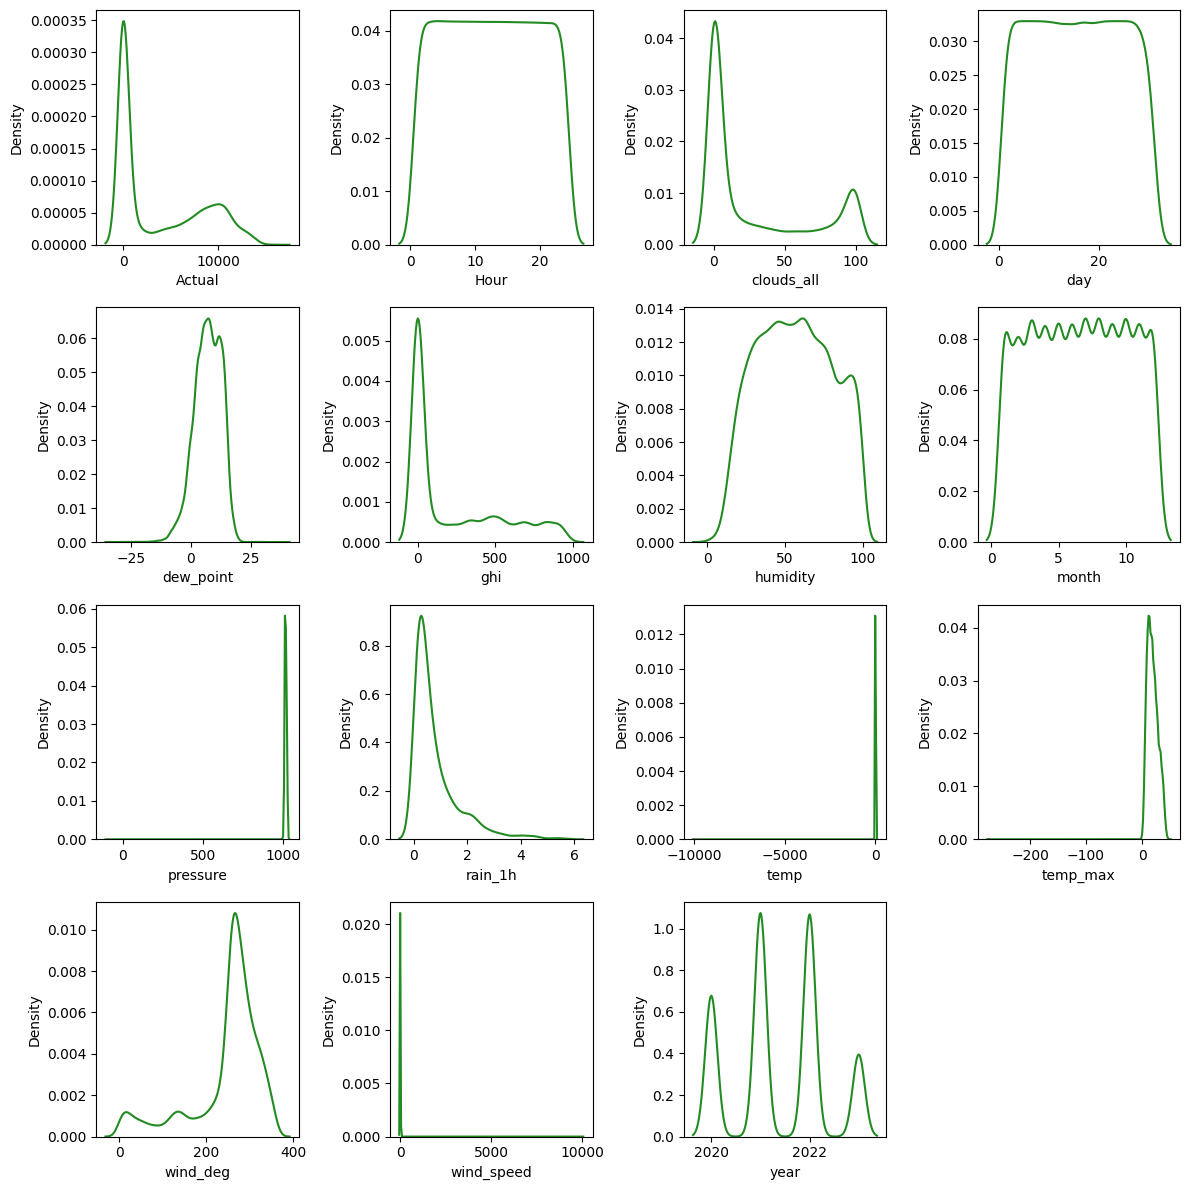

In [41]:
# Select only the numerical columns
num_df = final_df.select_dtypes(include=['int64', 'float64']).reset_index()

#plotting
plt.figure(figsize=(12,12))
for i in range(1, len(num_df.columns)):
    plt.subplot(4,4,i)
    sns.kdeplot(x=num_df[num_df.columns[i]], label='train', color='forestgreen')
    plt.tight_layout()

In [42]:
plt.figure(figsize=(15, 12))

for i in range(0, len(CAT[:-1])):
    plt.subplot(3, 4, i+1)
    ax = sns.countplot(x=final_df[CAT[i]], color='forestgreen')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

In [43]:
plt.figure(figsize=(12,12))
mask = np.triu(np.ones_like(final_df[NUM].corr()))
sns.heatmap(final_df[NUM].corr(), mask=mask, annot=True, fmt='.2f', cmap='YlGn_r')

<Axes: >

## Data Processing

In [44]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Combine numeric and categorical features
FEATURES = NUM + CAT

# Fill missing values with mean for numeric variables
imputer = SimpleImputer(strategy='mean')
numeric_df = pd.DataFrame(imputer.fit_transform(final_df[NUM]), columns=NUM)

# Scale numeric variables using min-max scaling
scaler = MinMaxScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=NUM)

# Encode categorical variables using one-hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cat_df = pd.DataFrame(encoder.fit_transform(final_df[CAT]), columns=encoder.get_feature_names_out(CAT))

# Concatenate the scaled numeric and encoded categorical variables
processed_df = pd.concat([scaled_numeric_df, encoded_cat_df], axis=1)

In [45]:
processed_df.head(5)

Actual      Hour  clouds_all  day  dew_point  ghi  humidity     month  \
0  0.005869  0.000000        0.83  0.5   0.565217  0.0      0.56  0.363636   
1  0.005869  0.043478        0.87  0.5   0.566048  0.0      0.58  0.363636   
2  0.005869  0.086957        0.95  0.5   0.564248  0.0      0.58  0.363636   
3  0.005869  0.130435        0.88  0.5   0.569233  0.0      0.65  0.363636   
4  0.005869  0.173913        0.76  0.5   0.574910  0.0      0.67  0.363636   

   pressure   rain_1h  ...  weather_icon_02n  weather_icon_03d  \
0  0.984982  0.124489  ...               0.0               0.0   
1  0.984099  0.124489  ...               0.0               0.0   
2  0.984099  0.124489  ...               0.0               0.0   
3  0.984099  0.124489  ...               0.0               0.0   
4  0.984099  0.124489  ...               0.0               0.0   

   weather_icon_03n  weather_icon_04d  weather_icon_04n  weather_icon_10d  \
0               0.0               0.0               1.0               0.0   
1               0.0               0.0               1.0               0.0   
2               0.0               0.0               1.0               0.0   
3               0.0               0.0               1.0               0.0   
4               0.0               0.0               1.0               0.0   

   weather_icon_10n  weather_main_Clear  weather_main_Clouds  \
0               0.0                 0.0                  1.0   
1               0.0                 0.0                  1.0   
2               0.0                 0.0                  1.0   
3               0.0                 0.0                  1.0   
4               0.0                 0.0                  1.0   

   weather_main_Rain  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  

[5 rows x 36 columns]

In [46]:
processed_df.shape

(26193, 36)

## Data Modeling

In [47]:
from sklearn.model_selection import train_test_split

# copying
df = processed_df.copy()

X = df.drop('Actual', axis=1)
y = df['Actual'].copy()

# Split dataset into train and test
X_train, X_test , y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 42)

# check the shapes of the training and test data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
X_train

X_train shape: (20954, 35)
y_train shape: (20954,)
X_test shape: (5239, 35)
y_test shape: (5239,)


Hour  clouds_all       day  dew_point       ghi  humidity  \
11674  0.434783        0.00  0.433333   0.626835  0.735463      0.33   
8341   0.565217        0.00  0.900000   0.507754  0.926765      0.22   
23589  0.478261        0.00  0.833333   0.576849  0.505766      0.83   
1097   0.739130        0.00  0.966667   0.594018  0.382561      0.24   
4291   0.826087        0.95  0.300000   0.494046  0.000000      0.62   
...         ...         ...       ...        ...       ...       ...   
21575  0.565217        0.01  0.066667   0.493492  0.565703      0.44   
5390   0.608696        0.97  0.833333   0.563694  0.368415      0.57   
860    0.869565        0.06  0.633333   0.660620  0.000000      0.52   
15795  0.782609        0.23  0.133333   0.439490  0.000000      0.42   
23654  0.173913        0.22  0.933333   0.523262  0.000000      0.82   

          month  pressure   rain_1h      temp  ...  weather_icon_02n  \
11674  0.727273  0.981449  0.124489  0.998345  ...               0.0   
8341   0.272727  0.989399  0.124489  0.998033  ...               0.0   
23589  0.000000  0.999117  0.124489  0.996468  ...               0.0   
1097   0.454545  0.978799  0.124489  0.998625  ...               0.0   
4291   0.909091  0.990283  0.124489  0.996283  ...               0.0   
...         ...       ...       ...       ...  ...               ...   
21575  0.909091  0.991166  0.124489  0.996796  ...               0.0   
5390   1.000000  0.992049  0.124489  0.996943  ...               0.0   
860    0.454545  0.982332  0.124489  0.997842  ...               0.0   
15795  0.181818  0.988516  0.124489  0.996414  ...               0.0   
23654  0.000000  0.982332  0.124489  0.996092  ...               1.0   

       weather_icon_03d  weather_icon_03n  weather_icon_04d  weather_icon_04n  \
11674               0.0               0.0               0.0               0.0   
8341                0.0               0.0               0.0               0.0   
23589               0.0               0.0               0.0               0.0   
1097                0.0               0.0               0.0               0.0   
4291                0.0               0.0               0.0               1.0   
...                 ...               ...               ...               ...   
21575               0.0               0.0               0.0               0.0   
5390                0.0               0.0               1.0               0.0   
860                 0.0               0.0               0.0               0.0   
15795               0.0               0.0               0.0               0.0   
23654               0.0               0.0               0.0               0.0   

       weather_icon_10d  weather_icon_10n  weather_main_Clear  \
11674               0.0               0.0                 1.0   
8341                0.0               0.0                 1.0   
23589               0.0               0.0                 1.0   
1097                0.0               0.0                 1.0   
4291                0.0               0.0                 0.0   
...                 ...               ...                 ...   
21575               0.0               0.0                 1.0   
5390                0.0               0.0                 0.0   
860                 0.0               0.0                 1.0   
15795               0.0               0.0                 0.0   
23654               0.0               0.0                 0.0   

       weather_main_Clouds  weather_main_Rain  
11674                  0.0                0.0  
8341                   0.0                0.0  
23589                  0.0                0.0  
1097                   0.0                0.0  
4291                   1.0                0.0  
...                    ...                ...  
21575                  0.0                0.0  
5390                   1.0                0.0  
860                    0.0                0.0  
15795                  1.0                0.0  

## Multiple Linear Regression

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,LogisticRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error


# define the final pipeline that includes the column transformer and a logistic regression model
pipe = Pipeline(steps=[('classifier', LinearRegression())])

In [49]:
# fit the pipeline to the training data
pipe.fit(X_train, y_train)

# evaluate the pipeline on the test data
score = pipe.score(X_test, y_test)
print(f'Test score: {score:.2f}')

Test score: 0.90


In [50]:
# Evaluate the pipeline on the testing data
y_pred = pipe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f}')

Mean squared error: 0.01


In [51]:
# Model complexity
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []
# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    lr = LinearRegression()
    # Fit with knn
    lr.fit(X_train,y_train)
    #train accuracy
    train_accuracy.append(lr.score(X_train, y_train))
    # test accuracy
    test_accuracy.append(lr.score(X_test, y_test))

# Plot
#plt.figure(figsize=[13,8])
plt.plot(neig, test_accuracy, label = 'Testing Accuracy')
plt.plot(neig, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('-value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()
print("Best accuracy is {}".format(np.max(test_accuracy)))

Best accuracy is 0.8987707572091397


In [52]:
# CV
from sklearn.model_selection import cross_val_score
reg = LinearRegression()
k = 10
cv_result = cross_val_score(reg,X_train,y_train,cv=k) # uses R^2 as score 
print('CV Scores: ',cv_result)
print('CV scores average: ',np.sum(cv_result)/k)

CV Scores:  [0.89677174 0.88472158 0.88956378 0.89323233 0.89252857 0.89264985
 0.8867505  0.8947866  0.90449044 0.89922107]
CV scores average:  0.8934716451410079


## XGBoost

In [53]:
# Set the seed for reproducibility
seed_value = 123
random.seed(seed_value)

In [54]:
my_model = xgb.XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, verbose=False)

# make predictions
y_pred = my_model.predict(X_test)


# Calculations
print("MAE  : " + str(mean_absolute_error(y_pred, y_test)))
print("RMSE : " + str(mean_squared_error(y_test, y_pred, squared=False)))

MAE  : 0.022555789172172932
RMSE : 0.040994318975822855


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

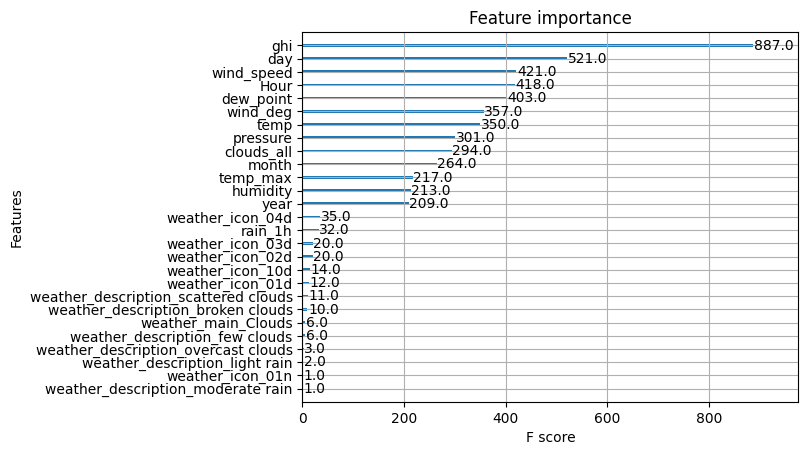

In [55]:
xgb.plot_importance(my_model)

In [56]:
# start_time = time.time()

# Define the objective function for Optuna
def objective(trial):
    
    # Define the search space for hyperparameters 
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'early_stopping_rounds': 100000, # Fix the boosting round and use early stopping
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'lambda': trial.suggest_float('lambda', 0.1, 10.0),
        'alpha': trial.suggest_float('alpha', 0.0, 10.0),
    }
    
    # Split the data into further training and validation sets (three sets are preferable)
    train_data, valid_data, train_target, valid_target = train_test_split(X_train, y_train, test_size=0.22, random_state=42)
    
    # Convert the data into DMatrix format
    dtrain = xgb.DMatrix(train_data, label=train_target)
    dvalid = xgb.DMatrix(valid_data, label=valid_target)
    
    # Define the pruning callback for early stopping
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation-rmse')
    
    # Train the model with early stopping
    model = xgb.train(param, dtrain, evals=[(dvalid, 'validation')], callbacks=[pruning_callback])
    
    # Make predictions on the test set
    dtest = xgb.DMatrix(valid_data)
    y_pred = model.predict(dtest)
    
    # Calculate the root mean squared error
    rmse = mean_squared_error(valid_target, y_pred, squared=False)
    
    return rmse


# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed_value))
study.optimize(objective, n_trials=100) # Control the number of trials

# Print the best hyperparameters and the best RMSE
best_params = study.best_params
best_rmse = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best RMSE: ", best_rmse)

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Elapsed time: {elapsed_time} seconds")

[I 2023-06-27 21:44:55,438] A new study created in memory with name: no-name-e54e1160-616d-4ac5-b99b-dec376c6204d


[21:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.30721
[1]	validation-rmse:0.24942
[2]	validation-rmse:0.20506
[3]	validation-rmse:0.17178
[4]	validation-rmse:0.14768
[5]	validation-rmse:0.12972
[6]	validation-rmse:0.11671
[7]	validation-rmse:0.10770
[8]	validation-rmse:0.09981
[9]	validation-rmse:0.09527


[I 2023-06-27 21:44:55,506] Trial 0 finished with value: 0.09526582459201836 and parameters: {'eta': 0.21197606382337986, 'max_depth': 5, 'subsample': 0.6134257267821015, 'colsample_bytree': 0.7756573845414456, 'gamma': 7.1946896978556305, 'min_child_weight': 4.288753955232163, 'lambda': 9.809565564007693, 'alpha': 6.848297385848633}. Best is trial 0 with value: 0.09526582459201836.


[21:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.32849
[1]	validation-rmse:0.28366
[2]	validation-rmse:0.24580
[3]	validation-rmse:0.21490
[4]	validation-rmse:0.18857
[5]	validation-rmse:0.16669
[6]	validation-rmse:0.14902
[7]	validation-rmse:0.13425
[8]	validation-rmse:0.12205
[9]	validation-rmse:0.11345


[I 2023-06-27 21:44:55,577] Trial 1 finished with value: 0.11344654484021673 and parameters: {'eta': 0.14947025143046466, 'max_depth': 6, 'subsample': 0.6715890080754348, 'colsample_bytree': 0.8645248536920208, 'gamma': 4.385722446796244, 'min_child_weight': 0.6908111764347267, 'lambda': 4.040638127771271, 'alpha': 7.379954057320357}. Best is trial 0 with value: 0.09526582459201836.


[21:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.35940
[1]	validation-rmse:0.33836
[2]	validation-rmse:0.31875
[3]	validation-rmse:0.30049
[4]	validation-rmse:0.28389
[5]	validation-rmse:0.26802
[6]	validation-rmse:0.25334
[7]	validation-rmse:0.23957
[8]	validation-rmse:0.22675
[9]	validation-rmse:0.21482


[I 2023-06-27 21:44:55,635] Trial 2 finished with value: 0.21481679446165824 and parameters: {'eta': 0.06292260183151499, 'max_depth': 4, 'subsample': 0.7657756869209191, 'colsample_bytree': 0.765913793548433, 'gamma': 6.344009585513211, 'min_child_weight': 8.509374761370117, 'lambda': 7.2721077161202885, 'alpha': 6.1102351067758285}. Best is trial 0 with value: 0.09526582459201836.


[21:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.30314
[1]	validation-rmse:0.24362
[2]	validation-rmse:0.19739
[3]	validation-rmse:0.16322
[4]	validation-rmse:0.13762
[5]	validation-rmse:0.12137
[6]	validation-rmse:0.10776
[7]	validation-rmse:0.09781
[8]	validation-rmse:0.08969
[9]	validation-rmse:0.08653


[I 2023-06-27 21:44:55,699] Trial 3 finished with value: 0.0865340016472039 and parameters: {'eta': 0.21950858094536424, 'max_depth': 5, 'subsample': 0.680894327811157, 'colsample_bytree': 0.6141316154394778, 'gamma': 2.9371404638882934, 'min_child_weight': 6.346663626159429, 'lambda': 1.0118389054562444, 'alpha': 4.337011726795282}. Best is trial 3 with value: 0.0865340016472039.


[21:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.33363
[1]	validation-rmse:0.29214
[2]	validation-rmse:0.25685
[3]	validation-rmse:0.22699
[4]	validation-rmse:0.20140
[5]	validation-rmse:0.17961
[6]	validation-rmse:0.16135
[7]	validation-rmse:0.14654
[8]	validation-rmse:0.13352
[9]	validation-rmse:0.12480


[I 2023-06-27 21:44:55,767] Trial 4 finished with value: 0.12479770969812949 and parameters: {'eta': 0.13495020136559668, 'max_depth': 6, 'subsample': 0.712915145147914, 'colsample_bytree': 0.6561306114862326, 'gamma': 4.2635130696280825, 'min_child_weight': 8.944552714859634, 'lambda': 9.447184180218409, 'alpha': 5.018366758843365}. Best is trial 3 with value: 0.0865340016472039.


[21:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.31455
[1]	validation-rmse:0.26173
[2]	validation-rmse:0.21904
[3]	validation-rmse:0.18579
[4]	validation-rmse:0.16114
[5]	validation-rmse:0.14192
[6]	validation-rmse:0.12739
[7]	validation-rmse:0.11630
[8]	validation-rmse:0.10837
[9]	validation-rmse:0.10259


[I 2023-06-27 21:44:55,834] Trial 5 finished with value: 0.10259125108506904 and parameters: {'eta': 0.19094635601971224, 'max_depth': 3, 'subsample': 0.6586427409101605, 'colsample_bytree': 0.7074131059768158, 'gamma': 8.66309157883366, 'min_child_weight': 2.5795081174254166, 'lambda': 4.882039216200773, 'alpha': 9.85559785610705}. Best is trial 3 with value: 0.0865340016472039.


[21:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-06-27 21:44:55,861] Trial 6 pruned. Trial was pruned at iteration 0.


[21:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-06-27 21:44:55,886] Trial 7 pruned. Trial was pruned at iteration 0.


[21:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29120
[1]	validation-rmse:0.23010
[2]	validation-rmse:0.18152
[3]	validation-rmse:0.14734
[4]	validation-rmse:0.12453
[5]	validation-rmse:0.11082
[6]	validation-rmse:0.09886
[7]	validation-rmse:0.09083
[8]	validation-rmse:0.08611
[9]	validation-rmse:0.08356


[I 2023-06-27 21:44:55,939] Trial 8 finished with value: 0.08355539170653871 and parameters: {'eta': 0.2542793069098746, 'max_depth': 3, 'subsample': 0.8818414207216692, 'colsample_bytree': 0.6218331872684371, 'gamma': 1.9422296057877086, 'min_child_weight': 5.767323879165583, 'lambda': 1.0475539144626325, 'alpha': 8.853268262751396}. Best is trial 8 with value: 0.08355539170653871.


[21:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.31421
[1]	validation-rmse:0.26026
[2]	validation-rmse:0.21742
[3]	validation-rmse:0.18377
[4]	validation-rmse:0.15892
[5]	validation-rmse:0.13900
[6]	validation-rmse:0.12434
[7]	validation-rmse:0.11376
[8]	validation-rmse:0.10603
[9]	validation-rmse:0.10074


[I 2023-06-27 21:44:56,015] Trial 9 finished with value: 0.10074294879940181 and parameters: {'eta': 0.19190220189486792, 'max_depth': 8, 'subsample': 0.5080646033475085, 'colsample_bytree': 0.7972159397225212, 'gamma': 5.567851923942887, 'min_child_weight': 1.6737004770327553, 'lambda': 1.6153980997352537, 'alpha': 6.955295287709109}. Best is trial 8 with value: 0.08355539170653871.


[21:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27441
[1]	validation-rmse:0.20069
[2]	validation-rmse:0.14999
[3]	validation-rmse:0.11657
[4]	validation-rmse:0.09471
[5]	validation-rmse:0.08317
[6]	validation-rmse:0.07480
[7]	validation-rmse:0.07057
[8]	validation-rmse:0.06911
[9]	validation-rmse:0.06746


[I 2023-06-27 21:44:56,123] Trial 10 finished with value: 0.06745806357069203 and parameters: {'eta': 0.29546288276202887, 'max_depth': 10, 'subsample': 0.9934534005473445, 'colsample_bytree': 0.5040305717020104, 'gamma': 0.46484135993505404, 'min_child_weight': 3.4602975905101037, 'lambda': 0.1379976279141717, 'alpha': 1.9925573196255622}. Best is trial 10 with value: 0.06745806357069203.


[21:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27362
[1]	validation-rmse:0.19899
[2]	validation-rmse:0.14775
[3]	validation-rmse:0.11363
[4]	validation-rmse:0.09110
[5]	validation-rmse:0.07886
[6]	validation-rmse:0.07044
[7]	validation-rmse:0.06614
[8]	validation-rmse:0.06415
[9]	validation-rmse:0.06208


[I 2023-06-27 21:44:56,233] Trial 11 finished with value: 0.062083447443727194 and parameters: {'eta': 0.29602382635648866, 'max_depth': 10, 'subsample': 0.9987711265329645, 'colsample_bytree': 0.5056299686767116, 'gamma': 0.11538076128504127, 'min_child_weight': 3.374203413519695, 'lambda': 0.14714830020306724, 'alpha': 1.0974914378391387}. Best is trial 11 with value: 0.062083447443727194.


[21:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27189
[1]	validation-rmse:0.19638
[2]	validation-rmse:0.14460
[3]	validation-rmse:0.10987
[4]	validation-rmse:0.08727
[5]	validation-rmse:0.07430
[6]	validation-rmse:0.06583
[7]	validation-rmse:0.06138
[8]	validation-rmse:0.05902
[9]	validation-rmse:0.05642


[I 2023-06-27 21:44:56,350] Trial 12 finished with value: 0.056421080214460004 and parameters: {'eta': 0.2983091432844877, 'max_depth': 10, 'subsample': 0.9892688183020396, 'colsample_bytree': 0.5080386522069729, 'gamma': 0.01355365204870182, 'min_child_weight': 3.0823961265545536, 'lambda': 0.2515317217779085, 'alpha': 0.11970761495335625}. Best is trial 12 with value: 0.056421080214460004.


[21:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27275
[1]	validation-rmse:0.19771
[2]	validation-rmse:0.14669
[3]	validation-rmse:0.11307
[4]	validation-rmse:0.09141
[5]	validation-rmse:0.07994
[6]	validation-rmse:0.07182
[7]	validation-rmse:0.06780
[8]	validation-rmse:0.06639
[9]	validation-rmse:0.06483


[I 2023-06-27 21:44:56,474] Trial 13 finished with value: 0.0648292556378032 and parameters: {'eta': 0.2991269540283724, 'max_depth': 10, 'subsample': 0.9997614616896698, 'colsample_bytree': 0.5029729024991976, 'gamma': 0.44247121863427996, 'min_child_weight': 0.14855978994200658, 'lambda': 2.5988350125205315, 'alpha': 0.14734489439888135}. Best is trial 12 with value: 0.056421080214460004.


[21:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28679
[1]	validation-rmse:0.21718
[2]	validation-rmse:0.16661
[3]	validation-rmse:0.13022
[4]	validation-rmse:0.10419
[5]	validation-rmse:0.08802
[6]	validation-rmse:0.07556
[7]	validation-rmse:0.06776
[8]	validation-rmse:0.06308
[9]	validation-rmse:0.05900


[I 2023-06-27 21:44:56,590] Trial 14 finished with value: 0.05900274423937584 and parameters: {'eta': 0.2570100902324692, 'max_depth': 9, 'subsample': 0.8635677850090263, 'colsample_bytree': 0.5585233937569009, 'gamma': 0.0014785242484469663, 'min_child_weight': 2.8194020414860943, 'lambda': 0.2504897611821134, 'alpha': 0.04941480271880039}. Best is trial 12 with value: 0.056421080214460004.


[21:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29097
[1]	validation-rmse:0.22442
[2]	validation-rmse:0.17574
[3]	validation-rmse:0.14135
[4]	validation-rmse:0.11678
[5]	validation-rmse:0.10125
[6]	validation-rmse:0.08982
[7]	validation-rmse:0.08247
[8]	validation-rmse:0.07766
[9]	validation-rmse:0.07484


[I 2023-06-27 21:44:56,702] Trial 15 finished with value: 0.07483631661669915 and parameters: {'eta': 0.2502582354725162, 'max_depth': 9, 'subsample': 0.8502884163079664, 'colsample_bytree': 0.5704112422157275, 'gamma': 1.843304637100517, 'min_child_weight': 2.002228440347584, 'lambda': 2.2222587992207763, 'alpha': 0.06170037721318433}. Best is trial 12 with value: 0.056421080214460004.


[21:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28949
[1]	validation-rmse:0.22245
[2]	validation-rmse:0.17381
[3]	validation-rmse:0.13954
[4]	validation-rmse:0.11538
[5]	validation-rmse:0.10067
[6]	validation-rmse:0.08938
[7]	validation-rmse:0.08256
[8]	validation-rmse:0.07810
[9]	validation-rmse:0.07553


[I 2023-06-27 21:44:56,806] Trial 16 finished with value: 0.07552758129065527 and parameters: {'eta': 0.2553919055867051, 'max_depth': 9, 'subsample': 0.8048623843554297, 'colsample_bytree': 0.5677063778333877, 'gamma': 1.672415117845981, 'min_child_weight': 4.078498461440942, 'lambda': 2.736474432939952, 'alpha': 2.1113090464733255}. Best is trial 12 with value: 0.056421080214460004.


[21:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28602
[1]	validation-rmse:0.21716
[2]	validation-rmse:0.16794
[3]	validation-rmse:0.13482
[4]	validation-rmse:0.11123
[5]	validation-rmse:0.09667
[6]	validation-rmse:0.08650
[7]	validation-rmse:0.08133
[8]	validation-rmse:0.07775
[9]	validation-rmse:0.07487


[I 2023-06-27 21:44:56,914] Trial 17 finished with value: 0.07486860887119627 and parameters: {'eta': 0.26536487541096904, 'max_depth': 8, 'subsample': 0.9101097078536182, 'colsample_bytree': 0.6831312485155323, 'gamma': 3.2020299334781046, 'min_child_weight': 1.3285015606964534, 'lambda': 1.6649343333624542, 'alpha': 1.0841879585293563}. Best is trial 12 with value: 0.056421080214460004.


[21:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28398
[1]	validation-rmse:0.21328
[2]	validation-rmse:0.16281
[3]	validation-rmse:0.12740
[4]	validation-rmse:0.10343
[5]	validation-rmse:0.08750
[6]	validation-rmse:0.07734
[7]	validation-rmse:0.07030
[8]	validation-rmse:0.06587
[9]	validation-rmse:0.06323


[I 2023-06-27 21:44:57,027] Trial 18 finished with value: 0.06322860235589203 and parameters: {'eta': 0.26928755481109135, 'max_depth': 9, 'subsample': 0.8463619491967252, 'colsample_bytree': 0.9938187588498406, 'gamma': 0.0017457108828015213, 'min_child_weight': 2.5515853783042948, 'lambda': 0.11854328620087351, 'alpha': 3.367091978156176}. Best is trial 12 with value: 0.056421080214460004.


[21:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29646


[I 2023-06-27 21:44:57,076] Trial 19 pruned. Trial was pruned at iteration 0.


[21:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28255
[1]	validation-rmse:0.21227
[2]	validation-rmse:0.16318
[3]	validation-rmse:0.13022
[4]	validation-rmse:0.10719
[5]	validation-rmse:0.09348
[6]	validation-rmse:0.08586
[7]	validation-rmse:0.08056
[8]	validation-rmse:0.07693
[9]	validation-rmse:0.07539


[I 2023-06-27 21:44:57,187] Trial 20 finished with value: 0.0753876869344987 and parameters: {'eta': 0.27538339215081015, 'max_depth': 9, 'subsample': 0.8155481959079812, 'colsample_bytree': 0.702118051676557, 'gamma': 2.4643357890420456, 'min_child_weight': 3.0659911650578975, 'lambda': 1.2773332795774857, 'alpha': 2.366678198009309}. Best is trial 12 with value: 0.056421080214460004.


[21:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27300
[1]	validation-rmse:0.19829
[2]	validation-rmse:0.14717
[3]	validation-rmse:0.11290
[4]	validation-rmse:0.09043
[5]	validation-rmse:0.07780
[6]	validation-rmse:0.06937
[7]	validation-rmse:0.06483
[8]	validation-rmse:0.06262
[9]	validation-rmse:0.06031


[I 2023-06-27 21:44:57,309] Trial 21 finished with value: 0.06031245796301907 and parameters: {'eta': 0.2973764175789263, 'max_depth': 10, 'subsample': 0.9648670798741338, 'colsample_bytree': 0.508599671274745, 'gamma': 0.01582860215569249, 'min_child_weight': 3.701989859302522, 'lambda': 0.30275368936646707, 'alpha': 1.0346113058427184}. Best is trial 12 with value: 0.056421080214460004.


[21:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27337
[1]	validation-rmse:0.19861
[2]	validation-rmse:0.14863
[3]	validation-rmse:0.11589
[4]	validation-rmse:0.09447
[5]	validation-rmse:0.08325
[6]	validation-rmse:0.07601
[7]	validation-rmse:0.07226
[8]	validation-rmse:0.06972
[9]	validation-rmse:0.06810


[I 2023-06-27 21:44:57,432] Trial 22 finished with value: 0.06809930976351058 and parameters: {'eta': 0.2986405483744581, 'max_depth': 10, 'subsample': 0.9451391773851766, 'colsample_bytree': 0.5383891087014391, 'gamma': 1.1288230918248892, 'min_child_weight': 3.8373254281789673, 'lambda': 1.013798226755109, 'alpha': 0.1272279511217543}. Best is trial 12 with value: 0.056421080214460004.


[21:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28322
[1]	validation-rmse:0.21342
[2]	validation-rmse:0.16374
[3]	validation-rmse:0.12941
[4]	validation-rmse:0.10604
[5]	validation-rmse:0.09250
[6]	validation-rmse:0.08235
[7]	validation-rmse:0.07680
[8]	validation-rmse:0.07277
[9]	validation-rmse:0.07093


[I 2023-06-27 21:44:57,558] Trial 23 finished with value: 0.07093316453763869 and parameters: {'eta': 0.2710648796487439, 'max_depth': 10, 'subsample': 0.9024061302856851, 'colsample_bytree': 0.6076899647248701, 'gamma': 1.2189673114465893, 'min_child_weight': 2.614004160937165, 'lambda': 0.10134281660021749, 'alpha': 1.1784746354086617}. Best is trial 12 with value: 0.056421080214460004.
[I 2023-06-27 21:44:57,617] Trial 24 pruned. Trial was pruned at iteration 0.


[21:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[21:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28088
[1]	validation-rmse:0.20894
[2]	validation-rmse:0.15839
[3]	validation-rmse:0.12342
[4]	validation-rmse:0.09926
[5]	validation-rmse:0.08535
[6]	validation-rmse:0.07536
[7]	validation-rmse:0.06936
[8]	validation-rmse:0.06580
[9]	validation-rmse:0.06311


[I 2023-06-27 21:44:57,724] Trial 25 finished with value: 0.06310513059497841 and parameters: {'eta': 0.27675897917601794, 'max_depth': 8, 'subsample': 0.8919741968417754, 'colsample_bytree': 0.5374472276403718, 'gamma': 0.06838743148280407, 'min_child_weight': 1.9411437271012297, 'lambda': 0.8401541370079635, 'alpha': 1.3330353387737746}. Best is trial 12 with value: 0.056421080214460004.


[21:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29702


[I 2023-06-27 21:44:57,780] Trial 26 pruned. Trial was pruned at iteration 0.


[21:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27960
[1]	validation-rmse:0.20767
[2]	validation-rmse:0.15732
[3]	validation-rmse:0.12358
[4]	validation-rmse:0.10054
[5]	validation-rmse:0.08616
[6]	validation-rmse:0.07780
[7]	validation-rmse:0.07321
[8]	validation-rmse:0.06933
[9]	validation-rmse:0.06788


[I 2023-06-27 21:44:57,895] Trial 27 finished with value: 0.06787770325017721 and parameters: {'eta': 0.28015284339817886, 'max_depth': 9, 'subsample': 0.871569537756902, 'colsample_bytree': 0.6423656442568768, 'gamma': 0.9295412455968018, 'min_child_weight': 0.9655569414922591, 'lambda': 0.769591844011339, 'alpha': 0.6682623560313234}. Best is trial 12 with value: 0.056421080214460004.


[21:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28104
[1]	validation-rmse:0.21067
[2]	validation-rmse:0.16133
[3]	validation-rmse:0.12845
[4]	validation-rmse:0.10583
[5]	validation-rmse:0.09336
[6]	validation-rmse:0.08472
[7]	validation-rmse:0.07909
[8]	validation-rmse:0.07600
[9]	validation-rmse:0.07388


[I 2023-06-27 21:44:57,997] Trial 28 finished with value: 0.07387992460404907 and parameters: {'eta': 0.2799798099872008, 'max_depth': 7, 'subsample': 0.9646590304818996, 'colsample_bytree': 0.5966298163572918, 'gamma': 3.280400445186755, 'min_child_weight': 4.996144675213559, 'lambda': 1.8094835294071374, 'alpha': 1.7929839386374948}. Best is trial 12 with value: 0.056421080214460004.


[21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29891


[I 2023-06-27 21:44:58,055] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2023-06-27 21:44:58,119] Trial 30 pruned. Trial was pruned at iteration 0.


[21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27457
[1]	validation-rmse:0.20024
[2]	validation-rmse:0.14914
[3]	validation-rmse:0.11519
[4]	validation-rmse:0.09276
[5]	validation-rmse:0.08061
[6]	validation-rmse:0.07212
[7]	validation-rmse:0.06769
[8]	validation-rmse:0.06575
[9]	validation-rmse:0.06375


[I 2023-06-27 21:44:58,242] Trial 31 finished with value: 0.06375066968649465 and parameters: {'eta': 0.29357326061209127, 'max_depth': 10, 'subsample': 0.9944555745142271, 'colsample_bytree': 0.5004724160865279, 'gamma': 0.25767200624578973, 'min_child_weight': 3.475040344106107, 'lambda': 0.1068790366182158, 'alpha': 0.8358033359334079}. Best is trial 12 with value: 0.056421080214460004.
[I 2023-06-27 21:44:58,303] Trial 32 pruned. Trial was pruned at iteration 0.


[21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27165
[1]	validation-rmse:0.19605
[2]	validation-rmse:0.14474
[3]	validation-rmse:0.11066
[4]	validation-rmse:0.08835
[5]	validation-rmse:0.07575
[6]	validation-rmse:0.06740
[7]	validation-rmse:0.06297
[8]	validation-rmse:0.06048
[9]	validation-rmse:0.05827


[I 2023-06-27 21:44:58,427] Trial 33 finished with value: 0.058267007262608 and parameters: {'eta': 0.2995553407918286, 'max_depth': 10, 'subsample': 0.9726435124283179, 'colsample_bytree': 0.5584449402143208, 'gamma': 0.022141896681278528, 'min_child_weight': 3.6206271661693537, 'lambda': 0.6743984060971593, 'alpha': 0.6575133942574147}. Best is trial 12 with value: 0.056421080214460004.


[21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27859
[1]	validation-rmse:0.20618
[2]	validation-rmse:0.15578
[3]	validation-rmse:0.12196
[4]	validation-rmse:0.09927
[5]	validation-rmse:0.08643
[6]	validation-rmse:0.07740
[7]	validation-rmse:0.07243
[8]	validation-rmse:0.06948
[9]	validation-rmse:0.06763


[I 2023-06-27 21:44:58,551] Trial 34 finished with value: 0.0676335896256517 and parameters: {'eta': 0.28241596581302575, 'max_depth': 10, 'subsample': 0.9690932578074282, 'colsample_bytree': 0.5575365453934409, 'gamma': 0.7921381521773004, 'min_child_weight': 4.567591844867803, 'lambda': 0.8762050891622359, 'alpha': 0.4232193126975484}. Best is trial 12 with value: 0.056421080214460004.


[21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28824


[I 2023-06-27 21:44:58,607] Trial 35 pruned. Trial was pruned at iteration 0.


[21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27866
[1]	validation-rmse:0.20787
[2]	validation-rmse:0.15760
[3]	validation-rmse:0.12340
[4]	validation-rmse:0.10129
[5]	validation-rmse:0.08904
[6]	validation-rmse:0.07979
[7]	validation-rmse:0.07465
[8]	validation-rmse:0.07127
[9]	validation-rmse:0.06884


[I 2023-06-27 21:44:58,702] Trial 36 finished with value: 0.06883513947345714 and parameters: {'eta': 0.28370356616094455, 'max_depth': 5, 'subsample': 0.8866937482936592, 'colsample_bytree': 0.5483778286437562, 'gamma': 0.6386612146161758, 'min_child_weight': 6.714492761437631, 'lambda': 1.3463637472474341, 'alpha': 0.5338040215219386}. Best is trial 12 with value: 0.056421080214460004.


[21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27418
[1]	validation-rmse:0.20105
[2]	validation-rmse:0.15181
[3]	validation-rmse:0.12091
[4]	validation-rmse:0.10039
[5]	validation-rmse:0.08973
[6]	validation-rmse:0.08214


[I 2023-06-27 21:44:58,801] Trial 37 pruned. Trial was pruned at iteration 6.


[21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-06-27 21:44:58,856] Trial 38 pruned. Trial was pruned at iteration 0.


[21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29450


[I 2023-06-27 21:44:58,912] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2023-06-27 21:44:58,966] Trial 40 pruned. Trial was pruned at iteration 0.


[21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[21:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27667
[1]	validation-rmse:0.20325
[2]	validation-rmse:0.15198
[3]	validation-rmse:0.11723
[4]	validation-rmse:0.09391
[5]	validation-rmse:0.08049
[6]	validation-rmse:0.07130
[7]	validation-rmse:0.06618
[8]	validation-rmse:0.06371
[9]	validation-rmse:0.06129


[I 2023-06-27 21:44:59,093] Trial 41 finished with value: 0.061288467824065405 and parameters: {'eta': 0.2870195743820525, 'max_depth': 10, 'subsample': 0.9928441441835012, 'colsample_bytree': 0.501711307551295, 'gamma': 0.0503083369131036, 'min_child_weight': 3.1592190587545947, 'lambda': 0.4053982527484745, 'alpha': 0.7904180894784063}. Best is trial 12 with value: 0.056421080214460004.


[21:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27800
[1]	validation-rmse:0.20459
[2]	validation-rmse:0.15381
[3]	validation-rmse:0.12003
[4]	validation-rmse:0.09707
[5]	validation-rmse:0.08384
[6]	validation-rmse:0.07476
[7]	validation-rmse:0.06977
[8]	validation-rmse:0.06690
[9]	validation-rmse:0.06477


[I 2023-06-27 21:44:59,217] Trial 42 finished with value: 0.06477452128205839 and parameters: {'eta': 0.28448444569029874, 'max_depth': 10, 'subsample': 0.9754122505896022, 'colsample_bytree': 0.5211923543018137, 'gamma': 0.5521792117557178, 'min_child_weight': 2.892323060710301, 'lambda': 1.1711260419074336, 'alpha': 0.09682009865397509}. Best is trial 12 with value: 0.056421080214460004.


[21:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28366


[I 2023-06-27 21:44:59,275] Trial 43 pruned. Trial was pruned at iteration 0.


[21:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27693
[1]	validation-rmse:0.20436
[2]	validation-rmse:0.15424
[3]	validation-rmse:0.12067
[4]	validation-rmse:0.09888
[5]	validation-rmse:0.08674
[6]	validation-rmse:0.07841
[7]	validation-rmse:0.07383


[I 2023-06-27 21:44:59,371] Trial 44 pruned. Trial was pruned at iteration 8.
[I 2023-06-27 21:44:59,430] Trial 45 pruned. Trial was pruned at iteration 0.


[21:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[21:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27764
[1]	validation-rmse:0.20571
[2]	validation-rmse:0.15619
[3]	validation-rmse:0.12342
[4]	validation-rmse:0.10118


[I 2023-06-27 21:44:59,516] Trial 46 pruned. Trial was pruned at iteration 5.
[I 2023-06-27 21:44:59,570] Trial 47 pruned. Trial was pruned at iteration 0.


[21:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[21:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27249
[1]	validation-rmse:0.19738
[2]	validation-rmse:0.14625
[3]	validation-rmse:0.11257
[4]	validation-rmse:0.09086
[5]	validation-rmse:0.07939
[6]	validation-rmse:0.07140
[7]	validation-rmse:0.06722
[8]	validation-rmse:0.06557
[9]	validation-rmse:0.06397


[I 2023-06-27 21:44:59,684] Trial 48 finished with value: 0.06396816699505345 and parameters: {'eta': 0.29864945915135516, 'max_depth': 9, 'subsample': 0.9817095792175308, 'colsample_bytree': 0.5014203039412395, 'gamma': 0.43609190031166806, 'min_child_weight': 2.874786157856253, 'lambda': 0.46078629262233806, 'alpha': 0.07276595180850376}. Best is trial 12 with value: 0.056421080214460004.
[I 2023-06-27 21:44:59,741] Trial 49 pruned. Trial was pruned at iteration 0.


[21:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-06-27 21:44:59,797] Trial 50 pruned. Trial was pruned at iteration 0.


[21:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[21:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27299
[1]	validation-rmse:0.19784
[2]	validation-rmse:0.14711
[3]	validation-rmse:0.11388
[4]	validation-rmse:0.09230
[5]	validation-rmse:0.08031
[6]	validation-rmse:0.07239
[7]	validation-rmse:0.06795
[8]	validation-rmse:0.06540
[9]	validation-rmse:0.06368


[I 2023-06-27 21:44:59,918] Trial 51 finished with value: 0.06367507599780346 and parameters: {'eta': 0.29891892551531424, 'max_depth': 10, 'subsample': 0.982700524502773, 'colsample_bytree': 0.5210521722667704, 'gamma': 0.46968708503798867, 'min_child_weight': 3.1846742379910373, 'lambda': 0.1978617855867603, 'alpha': 1.243529200049504}. Best is trial 12 with value: 0.056421080214460004.


[21:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27654
[1]	validation-rmse:0.20304
[2]	validation-rmse:0.15227
[3]	validation-rmse:0.11823
[4]	validation-rmse:0.09561
[5]	validation-rmse:0.08307
[6]	validation-rmse:0.07424
[7]	validation-rmse:0.06962
[8]	validation-rmse:0.06739
[9]	validation-rmse:0.06556


[I 2023-06-27 21:45:00,036] Trial 52 finished with value: 0.06555514682071609 and parameters: {'eta': 0.28840578276127116, 'max_depth': 10, 'subsample': 0.9379054599207558, 'colsample_bytree': 0.5071780908952455, 'gamma': 0.3566673464809997, 'min_child_weight': 3.7681670991164977, 'lambda': 0.4253971635282133, 'alpha': 0.5409296448067814}. Best is trial 12 with value: 0.056421080214460004.


[21:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28473


[I 2023-06-27 21:45:00,096] Trial 53 pruned. Trial was pruned at iteration 0.


[21:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27555
[1]	validation-rmse:0.20156
[2]	validation-rmse:0.15040
[3]	validation-rmse:0.11583
[4]	validation-rmse:0.09260
[5]	validation-rmse:0.07949
[6]	validation-rmse:0.07034
[7]	validation-rmse:0.06528
[8]	validation-rmse:0.06246
[9]	validation-rmse:0.05990


[I 2023-06-27 21:45:00,214] Trial 54 finished with value: 0.05990141257486016 and parameters: {'eta': 0.28936851014204834, 'max_depth': 9, 'subsample': 0.961067550674876, 'colsample_bytree': 0.562854245514182, 'gamma': 0.010108172752858902, 'min_child_weight': 2.923183002473811, 'lambda': 0.33722602659326917, 'alpha': 0.9912083680888526}. Best is trial 12 with value: 0.056421080214460004.


[21:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28185


[I 2023-06-27 21:45:00,269] Trial 55 pruned. Trial was pruned at iteration 0.


[21:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27638
[1]	validation-rmse:0.20235
[2]	validation-rmse:0.15139
[3]	validation-rmse:0.11750
[4]	validation-rmse:0.09463
[5]	validation-rmse:0.08102
[6]	validation-rmse:0.07303
[7]	validation-rmse:0.06840
[8]	validation-rmse:0.06522
[9]	validation-rmse:0.06347


[I 2023-06-27 21:45:00,387] Trial 56 finished with value: 0.06347192152300082 and parameters: {'eta': 0.288355036273537, 'max_depth': 9, 'subsample': 0.9273513795052502, 'colsample_bytree': 0.6673095095934682, 'gamma': 0.3071987356594414, 'min_child_weight': 2.1501588123596234, 'lambda': 1.3551347176559378, 'alpha': 0.9081523358272917}. Best is trial 12 with value: 0.056421080214460004.


[21:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-06-27 21:45:00,442] Trial 57 pruned. Trial was pruned at iteration 0.


[21:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-06-27 21:45:00,507] Trial 58 pruned. Trial was pruned at iteration 0.


[21:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27759
[1]	validation-rmse:0.20527
[2]	validation-rmse:0.15564
[3]	validation-rmse:0.12273
[4]	validation-rmse:0.10023


[I 2023-06-27 21:45:00,588] Trial 59 pruned. Trial was pruned at iteration 5.


[21:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27326
[1]	validation-rmse:0.19946
[2]	validation-rmse:0.14927
[3]	validation-rmse:0.11670
[4]	validation-rmse:0.09575
[5]	validation-rmse:0.08505


[I 2023-06-27 21:45:00,675] Trial 60 pruned. Trial was pruned at iteration 6.


[21:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27590
[1]	validation-rmse:0.20230
[2]	validation-rmse:0.15157
[3]	validation-rmse:0.11754
[4]	validation-rmse:0.09515
[5]	validation-rmse:0.08326
[6]	validation-rmse:0.07446
[7]	validation-rmse:0.06963
[8]	validation-rmse:0.06798
[9]	validation-rmse:0.06604


[I 2023-06-27 21:45:00,790] Trial 61 finished with value: 0.06603991388777208 and parameters: {'eta': 0.2907954816340232, 'max_depth': 10, 'subsample': 0.9800949628105063, 'colsample_bytree': 0.5005353491474023, 'gamma': 0.3760859654268506, 'min_child_weight': 3.405778971905429, 'lambda': 0.4259373031409386, 'alpha': 1.2636692927513422}. Best is trial 12 with value: 0.056421080214460004.


[21:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28157


[I 2023-06-27 21:45:00,849] Trial 62 pruned. Trial was pruned at iteration 0.


[21:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-06-27 21:45:00,908] Trial 63 pruned. Trial was pruned at iteration 0.


[21:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-06-27 21:45:00,974] Trial 64 pruned. Trial was pruned at iteration 0.


[21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27964


[I 2023-06-27 21:45:01,035] Trial 65 pruned. Trial was pruned at iteration 0.


[21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27546
[1]	validation-rmse:0.20132
[2]	validation-rmse:0.15076
[3]	validation-rmse:0.11689
[4]	validation-rmse:0.09417
[5]	validation-rmse:0.08190
[6]	validation-rmse:0.07323
[7]	validation-rmse:0.06853
[8]	validation-rmse:0.06572
[9]	validation-rmse:0.06389


[I 2023-06-27 21:45:01,159] Trial 66 finished with value: 0.06389382621102328 and parameters: {'eta': 0.2922234318974313, 'max_depth': 10, 'subsample': 0.9651524741691192, 'colsample_bytree': 0.5434425281454455, 'gamma': 0.22535015059614294, 'min_child_weight': 3.8507517631035153, 'lambda': 0.7363561991752603, 'alpha': 2.1007502369733855}. Best is trial 12 with value: 0.056421080214460004.


[21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28268


[I 2023-06-27 21:45:01,216] Trial 67 pruned. Trial was pruned at iteration 0.


[21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27989


[I 2023-06-27 21:45:01,275] Trial 68 pruned. Trial was pruned at iteration 0.


[21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-06-27 21:45:01,332] Trial 69 pruned. Trial was pruned at iteration 0.


[21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27316
[1]	validation-rmse:0.19900
[2]	validation-rmse:0.14856
[3]	validation-rmse:0.11567
[4]	validation-rmse:0.09480
[5]	validation-rmse:0.08376


[I 2023-06-27 21:45:01,424] Trial 70 pruned. Trial was pruned at iteration 6.


[21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27865
[1]	validation-rmse:0.20566
[2]	validation-rmse:0.15469
[3]	validation-rmse:0.11994
[4]	validation-rmse:0.09621
[5]	validation-rmse:0.08269
[6]	validation-rmse:0.07326
[7]	validation-rmse:0.06780
[8]	validation-rmse:0.06478
[9]	validation-rmse:0.06222


[I 2023-06-27 21:45:01,542] Trial 71 finished with value: 0.06221553828482919 and parameters: {'eta': 0.2811730074651242, 'max_depth': 8, 'subsample': 0.9679767773361877, 'colsample_bytree': 0.5294874322563092, 'gamma': 0.2579762135466428, 'min_child_weight': 1.8711419145864596, 'lambda': 0.38247702457753396, 'alpha': 0.041057342754302395}. Best is trial 12 with value: 0.056421080214460004.


[21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27426
[1]	validation-rmse:0.19984
[2]	validation-rmse:0.14885
[3]	validation-rmse:0.11493
[4]	validation-rmse:0.09210
[5]	validation-rmse:0.07941
[6]	validation-rmse:0.07098
[7]	validation-rmse:0.06632
[8]	validation-rmse:0.06370
[9]	validation-rmse:0.06158


[I 2023-06-27 21:45:01,654] Trial 72 finished with value: 0.06158154888379428 and parameters: {'eta': 0.292329754418421, 'max_depth': 8, 'subsample': 0.970961663769564, 'colsample_bytree': 0.5527367850096502, 'gamma': 0.2821214785068372, 'min_child_weight': 2.083956483922062, 'lambda': 0.3312880295834235, 'alpha': 0.010613065505254093}. Best is trial 12 with value: 0.056421080214460004.


[21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27493
[1]	validation-rmse:0.20082
[2]	validation-rmse:0.15011
[3]	validation-rmse:0.11627
[4]	validation-rmse:0.09367
[5]	validation-rmse:0.08156
[6]	validation-rmse:0.07302
[7]	validation-rmse:0.06851
[8]	validation-rmse:0.06588
[9]	validation-rmse:0.06395


[I 2023-06-27 21:45:01,781] Trial 73 finished with value: 0.06394929005425232 and parameters: {'eta': 0.29199900671325363, 'max_depth': 9, 'subsample': 0.9884734407101873, 'colsample_bytree': 0.5535536597847219, 'gamma': 0.433944801472828, 'min_child_weight': 2.803529352243351, 'lambda': 1.066819044908649, 'alpha': 0.5853093895723069}. Best is trial 12 with value: 0.056421080214460004.


[21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27548
[1]	validation-rmse:0.20164
[2]	validation-rmse:0.15073
[3]	validation-rmse:0.11699
[4]	validation-rmse:0.09519
[5]	validation-rmse:0.08354
[6]	validation-rmse:0.07511
[7]	validation-rmse:0.07061


[I 2023-06-27 21:45:01,882] Trial 74 pruned. Trial was pruned at iteration 7.


[21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-06-27 21:45:01,941] Trial 75 pruned. Trial was pruned at iteration 0.


[21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28496


[I 2023-06-27 21:45:02,001] Trial 76 pruned. Trial was pruned at iteration 0.


[21:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27827
[1]	validation-rmse:0.20586
[2]	validation-rmse:0.15507
[3]	validation-rmse:0.12004
[4]	validation-rmse:0.09648
[5]	validation-rmse:0.08282
[6]	validation-rmse:0.07285
[7]	validation-rmse:0.06690
[8]	validation-rmse:0.06253
[9]	validation-rmse:0.06019


[I 2023-06-27 21:45:02,109] Trial 77 finished with value: 0.060185888781494674 and parameters: {'eta': 0.28245929269551917, 'max_depth': 7, 'subsample': 0.9237606239603244, 'colsample_bytree': 0.617848318234321, 'gamma': 0.005532363560605033, 'min_child_weight': 2.6309290907000467, 'lambda': 1.1281052858261094, 'alpha': 0.6817558040258624}. Best is trial 12 with value: 0.056421080214460004.


[21:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27794
[1]	validation-rmse:0.20564


[I 2023-06-27 21:45:02,174] Trial 78 pruned. Trial was pruned at iteration 2.


[21:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28844


[I 2023-06-27 21:45:02,228] Trial 79 pruned. Trial was pruned at iteration 0.


[21:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27921


[I 2023-06-27 21:45:02,290] Trial 80 pruned. Trial was pruned at iteration 0.


[21:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27494
[1]	validation-rmse:0.20116
[2]	validation-rmse:0.15045
[3]	validation-rmse:0.11687
[4]	validation-rmse:0.09471
[5]	validation-rmse:0.08288
[6]	validation-rmse:0.07461
[7]	validation-rmse:0.07030


[I 2023-06-27 21:45:02,379] Trial 81 pruned. Trial was pruned at iteration 7.


[21:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28151


[I 2023-06-27 21:45:02,441] Trial 82 pruned. Trial was pruned at iteration 0.


[21:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27784
[1]	validation-rmse:0.20445
[2]	validation-rmse:0.15366
[3]	validation-rmse:0.11931
[4]	validation-rmse:0.09639
[5]	validation-rmse:0.08342
[6]	validation-rmse:0.07410
[7]	validation-rmse:0.06880
[8]	validation-rmse:0.06603
[9]	validation-rmse:0.06416


[I 2023-06-27 21:45:02,566] Trial 83 finished with value: 0.06416069498925657 and parameters: {'eta': 0.28519915429200876, 'max_depth': 9, 'subsample': 0.9712386883686462, 'colsample_bytree': 0.5427711505876904, 'gamma': 0.3350265010255357, 'min_child_weight': 3.31171241844278, 'lambda': 0.3413380758707233, 'alpha': 1.1376434624250373}. Best is trial 12 with value: 0.056421080214460004.


[21:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27527
[1]	validation-rmse:0.20361
[2]	validation-rmse:0.15287
[3]	validation-rmse:0.11942


[I 2023-06-27 21:45:02,644] Trial 84 pruned. Trial was pruned at iteration 4.


[21:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27207
[1]	validation-rmse:0.19655
[2]	validation-rmse:0.14519
[3]	validation-rmse:0.11081
[4]	validation-rmse:0.08853
[5]	validation-rmse:0.07590
[6]	validation-rmse:0.06750
[7]	validation-rmse:0.06257
[8]	validation-rmse:0.05980
[9]	validation-rmse:0.05702


[I 2023-06-27 21:45:02,755] Trial 85 finished with value: 0.057016738662396024 and parameters: {'eta': 0.2991745690948983, 'max_depth': 8, 'subsample': 0.9139025222833166, 'colsample_bytree': 0.5184788113264307, 'gamma': 0.027256168696312522, 'min_child_weight': 3.5997690214438824, 'lambda': 0.5813532099297887, 'alpha': 0.2620858061160257}. Best is trial 12 with value: 0.056421080214460004.


[21:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27170
[1]	validation-rmse:0.19627
[2]	validation-rmse:0.14490
[3]	validation-rmse:0.11059
[4]	validation-rmse:0.08804
[5]	validation-rmse:0.07561
[6]	validation-rmse:0.06721
[7]	validation-rmse:0.06238
[8]	validation-rmse:0.05877
[9]	validation-rmse:0.05689


[I 2023-06-27 21:45:02,869] Trial 86 finished with value: 0.056885390039033645 and parameters: {'eta': 0.29953523534914483, 'max_depth': 8, 'subsample': 0.9065870654855245, 'colsample_bytree': 0.6064052055755343, 'gamma': 0.020671027535044906, 'min_child_weight': 3.923196157637267, 'lambda': 0.5839320094470992, 'alpha': 0.32600257166629126}. Best is trial 12 with value: 0.056421080214460004.


[21:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27291
[1]	validation-rmse:0.19891
[2]	validation-rmse:0.14880
[3]	validation-rmse:0.11636
[4]	validation-rmse:0.09528


[I 2023-06-27 21:45:02,949] Trial 87 pruned. Trial was pruned at iteration 5.


[21:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28268


[I 2023-06-27 21:45:03,007] Trial 88 pruned. Trial was pruned at iteration 0.


[21:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27815


[I 2023-06-27 21:45:03,067] Trial 89 pruned. Trial was pruned at iteration 0.


[21:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-06-27 21:45:03,127] Trial 90 pruned. Trial was pruned at iteration 0.


[21:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27221
[1]	validation-rmse:0.19668
[2]	validation-rmse:0.14562
[3]	validation-rmse:0.11226
[4]	validation-rmse:0.09023
[5]	validation-rmse:0.07828
[6]	validation-rmse:0.07040
[7]	validation-rmse:0.06604
[8]	validation-rmse:0.06383
[9]	validation-rmse:0.06173


[I 2023-06-27 21:45:03,245] Trial 91 finished with value: 0.061734345622761026 and parameters: {'eta': 0.2998673068432472, 'max_depth': 8, 'subsample': 0.932491693326255, 'colsample_bytree': 0.5327673502454958, 'gamma': 0.3154218113690819, 'min_child_weight': 3.0205345460038235, 'lambda': 0.5926196107670775, 'alpha': 0.23222023398611602}. Best is trial 12 with value: 0.056421080214460004.


[21:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27486
[1]	validation-rmse:0.20064
[2]	validation-rmse:0.14953
[3]	validation-rmse:0.11547
[4]	validation-rmse:0.09282
[5]	validation-rmse:0.08037
[6]	validation-rmse:0.07181
[7]	validation-rmse:0.06680
[8]	validation-rmse:0.06406
[9]	validation-rmse:0.06183


[I 2023-06-27 21:45:03,360] Trial 92 finished with value: 0.061830395065271194 and parameters: {'eta': 0.29190047164748206, 'max_depth': 7, 'subsample': 0.9584209005450498, 'colsample_bytree': 0.5157706471598843, 'gamma': 0.23129034589806585, 'min_child_weight': 3.236535285908728, 'lambda': 0.28445371590280416, 'alpha': 0.0045535189377278185}. Best is trial 12 with value: 0.056421080214460004.


[21:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28004


[I 2023-06-27 21:45:03,417] Trial 93 pruned. Trial was pruned at iteration 0.


[21:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27692
[1]	validation-rmse:0.20310
[2]	validation-rmse:0.15202
[3]	validation-rmse:0.11728
[4]	validation-rmse:0.09371
[5]	validation-rmse:0.08032
[6]	validation-rmse:0.07105
[7]	validation-rmse:0.06570
[8]	validation-rmse:0.06258
[9]	validation-rmse:0.06026


[I 2023-06-27 21:45:03,541] Trial 94 finished with value: 0.06025698211913275 and parameters: {'eta': 0.2852816559321601, 'max_depth': 9, 'subsample': 0.9410996261000146, 'colsample_bytree': 0.5491580796219542, 'gamma': 0.14074210902059006, 'min_child_weight': 2.7723559890510234, 'lambda': 0.5033063913342671, 'alpha': 0.21959590804710985}. Best is trial 12 with value: 0.056421080214460004.


[21:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27713
[1]	validation-rmse:0.20344
[2]	validation-rmse:0.15223
[3]	validation-rmse:0.11723
[4]	validation-rmse:0.09354
[5]	validation-rmse:0.07990
[6]	validation-rmse:0.07035
[7]	validation-rmse:0.06479
[8]	validation-rmse:0.06171
[9]	validation-rmse:0.05905


[I 2023-06-27 21:45:03,664] Trial 95 finished with value: 0.059046908542737114 and parameters: {'eta': 0.28444779237321144, 'max_depth': 9, 'subsample': 0.9129518661356745, 'colsample_bytree': 0.5923058687399332, 'gamma': 0.05822697423371524, 'min_child_weight': 2.891767969460154, 'lambda': 0.613025148250948, 'alpha': 0.22354056194037641}. Best is trial 12 with value: 0.056421080214460004.


[21:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27802


[I 2023-06-27 21:45:03,728] Trial 96 pruned. Trial was pruned at iteration 0.
[I 2023-06-27 21:45:03,786] Trial 97 pruned. Trial was pruned at iteration 0.


[21:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[21:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28639


[I 2023-06-27 21:45:03,850] Trial 98 pruned. Trial was pruned at iteration 0.


[21:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27427
[1]	validation-rmse:0.20034
[2]	validation-rmse:0.15029
[3]	validation-rmse:0.11758
[4]	validation-rmse:0.09606


[I 2023-06-27 21:45:03,934] Trial 99 pruned. Trial was pruned at iteration 4.


Best Hyperparameters:  {'eta': 0.2983091432844877, 'max_depth': 10, 'subsample': 0.9892688183020396, 'colsample_bytree': 0.5080386522069729, 'gamma': 0.01355365204870182, 'min_child_weight': 3.0823961265545536, 'lambda': 0.2515317217779085, 'alpha': 0.11970761495335625}
Best RMSE:  0.056421080214460004


In [57]:
RMSE = 1 - best_rmse
print(RMSE*100)

94.357891978554


In [58]:
study.trials_dataframe()

#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [59]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [60]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [61]:
Best_trial = study.best_trial.params
Best_trial

{'eta': 0.2983091432844877,
 'max_depth': 10,
 'subsample': 0.9892688183020396,
 'colsample_bytree': 0.5080386522069729,
 'gamma': 0.01355365204870182,
 'min_child_weight': 3.0823961265545536,
 'lambda': 0.2515317217779085,
 'alpha': 0.11970761495335625}

In [62]:
# Set the seed for reproducibility
random.seed(seed_value)

preds = np.zeros(X_test.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
rmse=[]  # list contains rmse for each fold
n=0

for trn_idx, test_idx in kf.split(X_train,y_train):
    X_tr,X_val=X_train,X_test
    y_tr,y_val=y_train,y_test

    model = xgb.XGBRegressor(objective="reg:linear", seed=123, **Best_trial)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    
    preds+=model.predict(X_test)/kf.n_splits
    rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    
    print(f"fold: {n+1} ==> rmse: {rmse[n]}")
    n+=1

c:\Users\Hugo\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21:45:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
fold: 1 ==> rmse: 0.04423202703602173
[21:45:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


c:\Users\Hugo\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



fold: 2 ==> rmse: 0.04423202703602173
[21:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


c:\Users\Hugo\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



fold: 3 ==> rmse: 0.04423202703602173
[21:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


c:\Users\Hugo\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



fold: 4 ==> rmse: 0.04423202703602173
[21:45:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


c:\Users\Hugo\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



fold: 5 ==> rmse: 0.04423202703602173


In [80]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, scoring='r2', cv=5) 
r2_scores = np.mean(scores)
print("R-square:", r2_scores)

[21:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscal

In [64]:
preds = model.predict(X_test)
preds

array([0.00534558, 0.00508029, 0.00966737, ..., 0.01557101, 0.38159177,
       0.00552309], dtype=float32)

In [65]:
# Calculate the mean of RMSE values
mean_rmse = sum(rmse) / len(rmse)

# Calculate the RMSE
RMSE = (1 - mean_rmse) * 100

# Print the RMSE value
print("Accuracy:", "{:.2f}%".format(RMSE))

Accuracy: 95.58%


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

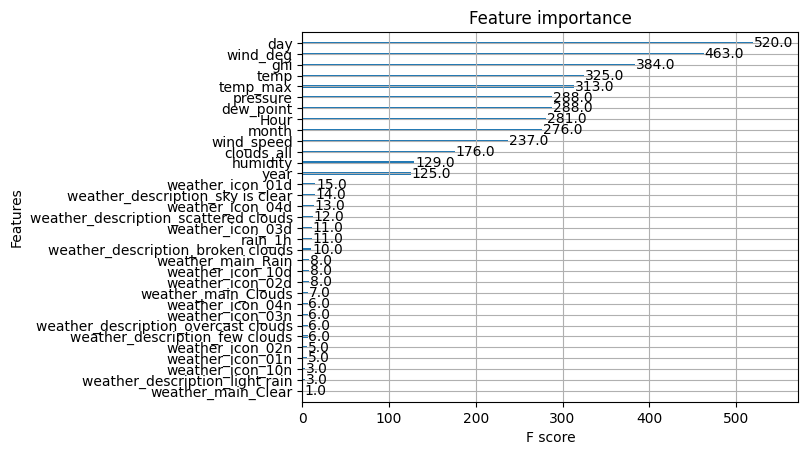

In [66]:
# Print feature importance
xgb.plot_importance(model)

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Generate the confusion matrix
y_pred = model.predict(X_test)
# Inverse transform the scaled predictions
#predictions = scaler.inverse_transform(predictions)
# Setting the prediction in a dataframe
#y_pred = pd.DataFrame(y_pred)

# Calcuate metrics
score_mae = mean_absolute_error(y_test, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print(y_pred)
print(score_mae)
print(score_rmse)

[0.00534558 0.00508029 0.00966737 ... 0.01557101 0.38159177 0.00552309]
0.02425409916096016
0.04423202703602173


In [68]:
import plotly.graph_objects as go


# Create traces for X_train and y_train
trace_train = go.Scatter(x=list(range(len(X_train))), y=y_train, name='Train')

# Create traces for y_pred and y_test
trace_pred = go.Scatter(x=list(range(len(X_train), len(X_train) + len(y_pred))), y=y_pred, name='Predictions')
trace_test = go.Scatter(x=list(range(len(X_train), len(X_train) + len(y_test))), y=y_test, name='Actual')

# Create the layout for the plot
layout = go.Layout(title='Model Predictions vs Actual',
                   xaxis=dict(title='Index'),
                   yaxis=dict(title='Value'))

# Combine the traces and layout into a figure
fig = go.Figure(data=[trace_train, trace_test, trace_pred], layout=layout)

# Show the figure
fig.show()


In [69]:
import plotly.graph_objects as go

# Create traces for y_pred and y_test
trace_pred = go.Scatter(x=list(range(len(y_pred))), y=y_pred, name='Predictions')
trace_test = go.Scatter(x=list(range(len(y_test))), y=y_test, name='Actual')

# Create the layout for the plot
layout = go.Layout(title='Model Predictions vs Actual',
                   xaxis=dict(title='Index'),
                   yaxis=dict(title='Value'))

# Combine the traces and layout into a figure
fig = go.Figure(data=[trace_pred, trace_test], layout=layout)

# Show the figure
fig.show()


In [70]:
fig = px.scatter(x=y_test, y=y_pred)
fig.show()

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
df_train_scaled_target = scaler.fit_transform(final_df[['Actual']])

# Reshape y_pred to match the expected input shape
y_pred = y_pred.reshape(-1, 1)

# Inverse transform the predictions
predictions = scaler.inverse_transform(y_pred)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0 : "Actual"}, inplace=True)

In [72]:
# Reshape y_pred to match the expected input shape
y_test = pd.array(y_test)
y_test = y_test.reshape(-1, 1)

# Inverse transform the predictions
actuals = scaler.inverse_transform(y_test)
actuals = pd.DataFrame(actuals)
actuals.rename(columns={0 : "Actual_True"}, inplace=True)

In [73]:
actuals[actuals<0] = 0
actuals

Actual_True
0             0.0
1             0.0
2             1.0
3          2650.0
4          4342.0
...           ...
5234       8775.0
5235          0.0
5236          0.0
5237       4981.0
5238          0.0

[5239 rows x 1 columns]

In [74]:
predictions[predictions<0] = 0
predictions

Actual
0        0.000000
1        0.000000
2       60.179512
3     1611.397949
4     3478.110596
...           ...
5234  8489.648438
5235    66.846657
5236   153.722687
5237  5953.321777
5238     0.000000

[5239 rows x 1 columns]

In [75]:
fig = px.scatter(x=actuals['Actual_True'], y=predictions['Actual'])
fig.show()

In [76]:
y_pred = pd.DataFrame(y_pred[-168:])
y_pred.rename(columns={0 : "Predictions (LW)"}, inplace=True)
y_pred

Predictions (LW)
0            0.577951
1            0.003314
2            0.006647
3            0.087676
4            0.008226
..                ...
163          0.541663
164          0.010088
165          0.015571
166          0.381592
167          0.005523

[168 rows x 1 columns]

In [77]:
y_test = pd.DataFrame(y_test[-168:])
y_test.rename(columns={0 : "Actual (LW)"}, inplace=True)
y_test

Actual (LW)
0       0.798612
1       0.007573
2       0.005869
3       0.133670
4       0.008331
..           ...
163     0.559672
164     0.005869
165     0.003219
166     0.320227
167     0.005869

[168 rows x 1 columns]

In [78]:
fig = px.scatter(x=y_pred['Predictions (LW)'], y=y_test['Actual (LW)'])
fig.show()

# Linear Regression Excluding 0 production hours & categorical variables (reference model)


In [ ]:
scale = MinMaxScaler()


# selecting only critical variables that are well known to affect power generation
data = data_full[['ghi','dni','clouds_all','Hour_DST','Actual']].copy()

#forcing negative values to 0
data.loc[data['Actual']<=0, 'Actual']=0

# removing na rows
data.dropna(inplace=True)

# limiting the data to hours with power generation
data = data.loc[(data['Hour_DST']>5)&(data['Hour_DST']<22)]
y = data['Actual'].copy()

# features scaling
# scaledX = scale.fit_transform(data.drop(['dni','clouds_all','Hour_DST','Actual'], axis=1))
# scaledX = pd.DataFrame(scaledX[0:], columns=['ghi'])

# features scaling
scaledX = scale.fit_transform(data.drop(['dew_point','clouds_all','Hour_DST','Actual'], axis=1))
scaledX = pd.DataFrame(scaledX[0:], columns=['ghi','dni'])

# features scaling
# scaledX = scale.fit_transform(data.drop(['Actual'], axis=1))
# scaledX = pd.DataFrame(scaledX[0:], columns=['ghi','dni','dew_point','clouds_all','Hour_DST'])

# cross validation
cv = KFold(n_splits = 5, random_state=42, shuffle=True)
lm = LinearRegression()
scores = cross_val_score(lm, scaledX.values, y, scoring='r2', cv=cv, n_jobs=-1)
print(scores)

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(scaledX[['ghi','dni']].values, y, test_size=0.2, random_state=42, shuffle=True)

# MLR modeling 
lm = LinearRegression()
lm.fit(X_train,y_train)
pred = lm.predict(X_test)

# error 
RMSE = metrics.mean_squared_error(y_test,pred)**0.5
print('RMSE: ', RMSE)

# MLR model fit quality
plt.scatter(y_test, pred)
plt.figure()
sns.histplot(y_test-pred, kde=True)

In [ ]:
# plotting actual and predicted power generation vs time for one week (week 20, year 2022)

plt.figure()
Actual_model = lm.predict(scaledX[['ghi','dni']].values)

# forcing negative values to 0
Actual_model[Actual_model<0]=0

# limiting the data to hours with power generation
data_full_ = data_full.loc[(data_full['Hour_DST']>5)&(data['Hour_DST']<22)].copy()
data_full_.reset_index(inplace=True)

for e in [2021]:
    data_y_ = data_full_[data_full_['year']==e].copy()
    
        
    for i in [31]:
        data_w_ = data_y_[data_y_['week']==i].copy()
        
#         plt.figure()
        for j in data_w_['day'].unique():
            plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],data_w_[data_w_['day']==j]['Actual'])
            
            
            index = data_w_[data_w_['day']==j].index
            plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],Actual_model[list(index)])
#             index = data_w_[data_w_['day']==j]['Hour_DST'],data_w_[data_w_['day']==j]['Actual'].index
#             plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],Actual_model[list(index[1])])
            plt.figure()


plt.plot(range(112),data_w_['Actual'])
index = data_w_.index
plt.plot(range(112),Actual_model[list(index)])
            

# Random Forest Model

In [ ]:
scale = MinMaxScaler()

# selecting all numeric variables
data = data_full[['ghi','dni','dew_point','clouds_all','Hour_DST','Actual','week','humidity','pressure','temp','wind_speed']].copy()

#forcing negative values to 0
data.loc[data['Actual']<=0, 'Actual']=0

# removing na rows
data.dropna(inplace=True)

# limiting the data to hours with power generation
data = data.loc[(data['Hour_DST']>5)&(data['Hour_DST']<22)]
y = data['Actual'].copy()

# features scaling
scaledX = scale.fit_transform(data.drop('Actual', axis=1))
scaledX = pd.DataFrame(scaledX, columns=['ghi','dni','dew_point','clouds_all','Hour_DST','week','humidity','pressure','temp','wind_speed'])


In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(scaledX[['ghi','dni','clouds_all','humidity','pressure','week']].values, y, test_size=0.2, random_state=42, shuffle=True)

# random forest modeling
rf_model = RandomForestRegressor()
rf_model.fit(X_train,y_train)
pred = rf_model.predict(X_test)

# error
RMSE = metrics.mean_squared_error(y_test,pred)**0.5
r2 = metrics.r2_score(y_test,pred)
print('RMSE: ', RMSE)
print('r2: ', r2)

# random forest model fit quality
plt.scatter(y_test, pred)
plt.figure()
sns.histplot(y_test-pred, kde=True)

In [ ]:
# plotting actual and predicted power generation vs time for one week (week 20, year 2022)

plt.figure()
Actual_model = rf_model.predict(scaledX[['ghi','dni','clouds_all','humidity','pressure','week']].values)

# forcing negative values to 0
Actual_model[Actual_model<0]=0

# limiting the data to hours with power generation
data_full_ = data_full.loc[(data_full['Hour_DST']>5)&(data['Hour_DST']<22)].copy()
data_full_.reset_index(inplace=True)

for e in [2021]:
    data_y_ = data_full_[data_full_['year']==e].copy()
    
        
    for i in [31]:
        data_w_ = data_y_[data_y_['week']==i].copy()
        
#         plt.figure()
        for j in data_w_['day'].unique():
            plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],data_w_[data_w_['day']==j]['Actual'])
            
            
            index = data_w_[data_w_['day']==j].index
            plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],Actual_model[list(index)])
#             index = data_w_[data_w_['day']==j]['Hour_DST'],data_w_[data_w_['day']==j]['Actual'].index
#             plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],Actual_model[list(index[1])])
            plt.figure()

plt.plot(range(112),data_w_['Actual'])
index = data_w_.index
plt.plot(range(112),Actual_model[list(index)])

# Time Series Modeling

# AR Model

In [ ]:
#forcing negative values to 0
data_full.loc[data_full['Actual']<=0, 'Actual']=0

#find the optimal number of lags (optimal is 74)
train = data_full['Actual'][:-167].copy()
test = data_full['Actual'][-167:].copy()
plot_pacf(train, lags=96)

In [ ]:
#error calculation 
RMSE=[]

for i in range(26):
    
    #train-test split
    train = data_full['Actual'][1000*i:1000*(i+1)].copy()
    test = data_full['Actual'][1000*(i+1)+1:1000*(i+1)+169].copy()

    #model fit
    time_searies_model = AutoReg(train, lags=74).fit()

    #1-week forecast
    pred = time_searies_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    pred[pred<0]=0
    
    #plt.scatter(test, pred)
    #plt.figure()
    #plt.plot(range(168),test)
    #plt.plot(range(168),pred)
    #plt.figure()
    
    #RMSE 
    er = (test.reset_index(drop=True) - pred.reset_index(drop=True))**2
    er = er**0.5
    RMSE.append(er.mean())


plt.plot(RMSE)
sum(RMSE)/len(RMSE)


# model performance in 3 different weeks
for i in [1,13,25]:
    train = data_full['Actual'][1000*i:1000*(i+1)].copy()
    test = data_full['Actual'][1000*(i+1)+1:1000*(i+1)+169].copy()

    #model fit
    time_searies_model = AutoReg(train, lags=74).fit()

    #1-week forecast
    pred = time_searies_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    pred[pred<0]=0
    
    plt.plot(range(168),test)
    plt.plot(range(168),pred)
    plt.figure()

# (ARIMA) & (ARMA) not good results 